# Pipeline for High-z Radio Galaxies 10: SHAP values for base models in prediction

In this notebook, we aim to obtain a SHAP analysis for a sub-sample of our catalogue in the base-learners used for predictions.  
It is possible to select either a random sample from the predicted pipeline (non-star, radio AGN) or high-redshift sources,  
regardless of their predicted values.

In [1]:
%matplotlib inline
# Static plots
#%matplotlib ipympl
# Interactive plots
import copy
import numpy as np
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.patheffects as mpe
import sklearn.pipeline
from sklearn.model_selection import train_test_split
import colorcet as cc
import cmasher as cmr
from pycaret import classification as pyc
from pycaret import regression as pyr
from joblib import dump, load
import pandas as pd
import shap
import fasttreeshap
import global_variables as gv
import global_functions as gf

In [2]:
mpl.rcdefaults()

In [3]:
plt.rcParams['text.usetex'] = True

---

In [4]:
save_plot_flag      = False
load_models_flag    = True
use_zeroth_model    = False  # Initial model to discriminate between star and non-star objects
use_second_z_model  = False
use_calibration     = True
use_high_z_sources  = True  # If True, run on original high-z sources. False for running on random set of predicted non-star, rAGN.
use_unknown         = False  # False for using previously confirmed sources (AGN, Galaxies)

### Load data

Any of the available areas could be used. But we aim to Stripe 82 since we want to understand, with SHAP, predictions and not training.

In [5]:
used_area          = 'HETDEX'  # can be 'S82', 'HETDEX', 'COSMOS'
HETDEX_subset      = 'Test_Train'  # Validation, Training, Test, Test_Train
if not use_high_z_sources:
    if used_area == 'HETDEX':
        subset_str = f'_{HETDEX_subset}'
    if used_area != 'HETDEX':
        subset_str = ''
elif use_high_z_sources:
    subset_str     = ''

In [6]:
file_name_dict      = {'S82': gv.file_S82, 'HETDEX': gv.file_HETDEX, 'COSMOS': gv.file_COSMOS}
file_name           = file_name_dict[used_area]

In [7]:
feats_2_disc_S82    = ['objID', 'RA_MILLI', 'DEC_MILLI', 'W1mag', 'W2mag', 'num_imputed', 'radio_detect']
feats_2_disc_HETDEX = ['objID', 'RA_MILLI', 'DEC_MILLI', 'W1mag', 'W2mag', 'num_imputed', 'radio_detect']
feats_2_disc_COSMOS = ['objID', 'RA_MILLI', 'DEC_MILLI', 'W1mag', 'W2mag', 'num_imputed', 'radio_detect']

feats_2_disc        = {'S82': feats_2_disc_S82, 'HETDEX': feats_2_disc_HETDEX, 'COSMOS': feats_2_disc_COSMOS}
features_2_discard  = feats_2_disc[used_area]

In [8]:
full_catalog_df     = pd.read_hdf(gv.cat_path + file_name, key='df').drop(columns=features_2_discard)

In [9]:
if used_area == 'S82':
    full_catalog_df.loc[:, 'LOFAR_detect'] = full_catalog_df.loc[:, 'VLAS82_detect'].copy()
    full_catalog_df = full_catalog_df.drop(columns=['VLAS82_detect'])
if used_area == 'COSMOS':
    full_catalog_df.loc[:, 'LOFAR_detect'] = full_catalog_df.loc[:, 'COSMOSVLA3_detect'].copy()
    full_catalog_df = full_catalog_df.drop(columns=['COSMOSVLA3_detect'])

Create features with class and combined redshift.

In [10]:
full_catalog_df['class']            = full_catalog_df.loc[:, 'is_AGN'].copy()
if use_zeroth_model:
    filter_non_confirmed            = np.array(full_catalog_df.loc[:, 'is_AGN'] == 1) |\
                                      np.array(full_catalog_df.loc[:, 'is_gal'] == 1) |\
                                      np.array(full_catalog_df.loc[:, 'is_str'] == 1)
    full_catalog_df.loc[np.array(full_catalog_df.loc[:, 'is_str'] == 1), 'class'] = 2
elif not use_zeroth_model:
    filter_non_confirmed            = np.array(full_catalog_df.loc[:, 'is_AGN'] == 1) |\
                                      np.array(full_catalog_df.loc[:, 'is_gal'] == 1)
full_catalog_df.loc[~filter_non_confirmed, 'class'] = 0.5
idx_non_Z                           = full_catalog_df.loc[:, 'Z'].where(full_catalog_df.loc[:, 'Z'] > 0).isna()
full_catalog_df.loc[idx_non_Z, 'Z'] = full_catalog_df.loc[:, 'Z'].mask(idx_non_Z, full_catalog_df.loc[idx_non_Z, 'zsp'])

In [11]:
full_catalog_df['radio_AGN']        = np.array(full_catalog_df.loc[:, 'is_AGN'] == 1) & np.array(full_catalog_df.loc[:, 'LOFAR_detect'] == 1)

#### Select relevant sources

In [12]:
if use_high_z_sources:  # Only use high-z AGN
    # filter_selection   = np.array(full_catalog_df.loc[:, 'Z'] >= gv.high_z_limit)
    filter_selection   = np.array(full_catalog_df.loc[:, 'Z'] >= 4.0) & np.array(full_catalog_df.loc[:, 'class'] == 1)
    full_catalog_df    = full_catalog_df.loc[filter_selection]
    high_z_str         = '_high_z'
if not use_high_z_sources:
    high_z_str         = ''

In [13]:
if not use_high_z_sources:
    if used_area == 'HETDEX':
        if use_zeroth_model:
            filter_known_spec = (full_catalog_df.loc[:, 'is_AGN'] == 1) |\
                (full_catalog_df.loc[:, 'is_gal'] == 1) | (full_catalog_df.loc[:, 'is_str'] == 1)
        elif not use_zeroth_model:
            filter_known_spec = (full_catalog_df.loc[:, 'is_AGN'] == 1) | (full_catalog_df.loc[:, 'is_gal'] == 1)
        unknown_cat_df    = full_catalog_df.loc[~filter_known_spec]
        full_catalog_df   = full_catalog_df.loc[filter_known_spec]
        train_test_df, train_df, test_df, calibration_df, validation_df = gf.split_set(full_catalog_df, [0.2, 0.2, 0.5],\
                                                                                   'is_AGN', use_calibration=use_calibration)
        print('Shape of used data in HETDEX')
        print('-' * 65)
        print(f'Full confirmed dataset size:                      {full_catalog_df.shape}')
        print(f'Data for Modeling (Train, Test, and Calibration): {train_test_df.shape}')
        print(f'Training data:                                    {train_df.shape}')
        print(f'Testing data:                                     {test_df.shape}')
        if use_calibration:
            print(f'Calibration data:                                 {calibration_df.shape}')
        print(f'Validation data:                                  {validation_df.shape}')
        print('-' * 65)
        print()
        print(f'Using {HETDEX_subset} data from HETDEX')
        selected_dataset = {'Training': train_df, 'Test': test_df, 'Test_Train': train_test_df,\
                            'Validation': validation_df, 'Calibration': calibration_df}
        full_catalog_df = selected_dataset[HETDEX_subset]

In [14]:
if not use_high_z_sources:
    if used_area != 'HETDEX':
        filter_confirmed = (full_catalog_df.loc[:, 'class'] == 0) |\
                           (full_catalog_df.loc[:, 'class'] == 1) |\
                           (full_catalog_df.loc[:, 'class'] == 2)  # Galaxy, AGN, star
        unknown_cat_df   = full_catalog_df.loc[~filter_confirmed]
        full_catalog_df  = full_catalog_df.loc[filter_confirmed]

In [15]:
full_catalog_df          = full_catalog_df.drop(columns=['is_AGN', 'is_SDSS_gal', 'is_gal', 'zsp'])

In [16]:
if not use_high_z_sources:
    if use_unknown:
        full_catalog_df = unknown_cat_df
    filter_selection   = np.ones_like(full_catalog_df.loc[:, 'class']).astype(bool)

In [17]:
print(f'Full used dataset size:              {full_catalog_df.shape}')
print('-' * 50)
print(f'Thus, it has {full_catalog_df.shape[0]:,} sources and {full_catalog_df.shape[1]:,} features.')
print(f'From them, {np.sum(full_catalog_df.loc[:, "class"] == 1)} are confirmed AGN.')
print(f'From all the sources, {np.sum(full_catalog_df.loc[:, "LOFAR_detect"] == 1)} have radio (LOFAR-like) detection.')
print(f'From the {np.sum(full_catalog_df.loc[:, "class"] == 1)} AGN,\
 {np.sum((full_catalog_df.loc[:, "class"] == 1) & (full_catalog_df.loc[:, "LOFAR_detect"] == 1))} have radio (LOFAR-like) detection.')

Full used dataset size:              (121, 97)
--------------------------------------------------
Thus, it has 121 sources and 97 features.
From them, 121 are confirmed AGN.
From all the sources, 29 have radio (LOFAR-like) detection.
From the 121 AGN, 29 have radio (LOFAR-like) detection.


### Load models

In [18]:
if load_models_flag:
    if use_zeroth_model:
        star_clf        = pyc.load_model(gv.models_path + gv.star_model)  # star/no-star model
        cal_star_clf    = load(gv.models_path + gv.cal_str_model)  # calibrated model
    AGN_gal_clf         = pyc.load_model(gv.models_path + gv.AGN_gal_model)  #
    cal_AGN_gal_clf     = load(gv.models_path + gv.cal_AGN_gal_model)  # calibrated model
    radio_det_clf       = pyc.load_model(gv.models_path + gv.radio_model)  # without predicted AGN
    cal_radio_det_clf   = load(gv.models_path + gv.cal_radio_model)  # calibrated model
    redshift_reg        = pyr.load_model(gv.models_path + gv.full_z_model)  # to use on full sample
    if use_second_z_model:
        redshift_reg_2  = pyr.load_model(gv.models_path + gv.high_z_model)  # sources with predicted z >= 3.6

Transformation Pipeline and Model Successfully Loaded
Transformation Pipeline and Model Successfully Loaded
Transformation Pipeline and Model Successfully Loaded


In [19]:
if use_zeroth_model:
    threshold_star_logit = np.log(gv.star_thresh  / (1 - gv.star_thresh))
threshold_AGN_logit      = np.log(gv.AGN_thresh   / (1 - gv.AGN_thresh))
threshold_radio_logit    = np.log(gv.radio_thresh / (1 - gv.radio_thresh))

#### Predictions

In [20]:
if use_zeroth_model:  # we want no-star sources => label == 0
    full_catalog_df = pyc.predict_model(star_clf, data=full_catalog_df, probability_threshold=gv.star_thresh, raw_score=True, round=10)
    full_catalog_df = full_catalog_df.drop(columns=['Score_1'])
    full_catalog_df = full_catalog_df.rename(columns={'Label': 'pred_star', 'Score_0': 'Score_no_star'})
    full_catalog_df.loc[:, 'Score_no_star'] = np.around(full_catalog_df.loc[:, 'Score_no_star'], decimals=7)
elif not use_zeroth_model:
    full_catalog_df['pred_star']     = 0
    full_catalog_df['Score_no_star'] = 1

In [21]:
full_catalog_df = pyc.predict_model(AGN_gal_clf, data=full_catalog_df, probability_threshold=gv.AGN_thresh, raw_score=True, round=10)
full_catalog_df = full_catalog_df.drop(columns=['Score_0'])
full_catalog_df = full_catalog_df.rename(columns={'Label': 'pred_class', 'Score_1': 'Score_AGN'})
full_catalog_df.loc[:, 'Score_AGN'] = np.around(full_catalog_df.loc[:, 'Score_AGN'], decimals=6)

In [22]:
full_catalog_df = pyc.predict_model(radio_det_clf, data=full_catalog_df, probability_threshold=gv.radio_thresh, raw_score=True, round=10)
full_catalog_df = full_catalog_df.drop(columns=['Score_0'])
full_catalog_df = full_catalog_df.rename(columns={'Label': 'pred_radio', 'Score_1': 'Score_radio'})
full_catalog_df.loc[:, 'Score_radio'] = np.around(full_catalog_df.loc[:, 'Score_radio'], decimals=6)

In [23]:
full_catalog_df = pyr.predict_model(redshift_reg, data=full_catalog_df, round=8)
full_catalog_df = full_catalog_df.rename(columns={'Label': 'pred_Z'})
full_catalog_df.loc[:, 'pred_Z'] = np.around(full_catalog_df.loc[:, 'pred_Z'], decimals=3)

In [24]:
redshift_tol    = 0.0
if use_second_z_model:
    full_catalog_df = pyr.predict_model(redshift_reg_2, data=full_catalog_df, round=6)
    filter_pred_z   = full_catalog_df.loc[:, 'pred_Z'] >= (gv.high_z_limit + redshift_tol)
    full_catalog_df.loc[:, 'pred_Z'] = full_catalog_df.loc[:, 'pred_Z'].mask(filter_pred_z, full_catalog_df.loc[filter_pred_z, 'Label'])
    full_catalog_df = full_catalog_df.drop(columns=['Label'])
    full_catalog_df.loc[:, 'pred_Z'] = np.around(full_catalog_df.loc[:, 'pred_Z'], decimals=3)

In [25]:
full_catalog_df['pred_radio_AGN'] = np.array(full_catalog_df.loc[:, 'pred_star'] == 0) &\
                                    np.array(full_catalog_df.loc[:, 'pred_class'] == 1) &\
                                    np.array(full_catalog_df.loc[:, 'pred_radio'] == 1)

---

## Use SHAP

Flags to run on sub-set of base learners.

In [26]:
run_shap_AGN_base    = True
run_shap_radio_base  = True
run_shap_z_base      = True
run_shap_high_z_base = True

In [27]:
if use_zeroth_model:
    filter_pred_no_str = np.array(full_catalog_df.loc[:, 'pred_star'] == 0)
elif not use_zeroth_model:
    filter_pred_no_str = np.ones_like(full_catalog_df.loc[:, 'class']).astype(bool)

#### SHAP - AGN/galaxy model

In [28]:
if run_shap_AGN_base:
    model_name_AGN = type(AGN_gal_clf.named_steps['trained_model'].final_estimator_).__name__.replace('Classifier', '')

SHAP does not need to use the full dataset for its analysis. Around $N=1000$ (or less) is a good number.

In [29]:
if run_shap_AGN_base:
    sample_size_AGN  = 1000
    sub_size_AGN     = np.nanmin([sample_size_AGN, np.sum(filter_pred_no_str)])
    print(f'Number of selected elements: {sub_size_AGN:,}')

Number of selected elements: 121


In [30]:
if run_shap_AGN_base:
    base_models_names_AGN = gf.get_base_estimators_names(AGN_gal_clf)

In [31]:
if run_shap_AGN_base:
    reduced_data_AGN    = full_catalog_df.loc[filter_pred_no_str].sample(n=sub_size_AGN, random_state=gv.seed).copy()
    display(reduced_data_AGN.loc[:, ['class', 'pred_class']].describe())
    reduced_data_AGN_df = gf.preprocess_data(AGN_gal_clf, reduced_data_AGN, base_models_names_AGN)
    reduced_cols_AGN    = reduced_data_AGN_df.columns.drop(base_models_names_AGN)

class  pred_class
count  121.0  121.000000
mean     1.0    0.859504
std      0.0    0.348946
min      1.0    0.000000
25%      1.0    1.000000
50%      1.0    1.000000
75%      1.0    1.000000
max      1.0    1.000000

Use FastTreeSHAP package

In [32]:
if run_shap_AGN_base:
    explainers_AGN_base = {}
    for model, model_fit in zip(AGN_gal_clf.named_steps['trained_model'].estimators, AGN_gal_clf.named_steps['trained_model'].estimators_):
        explainers_AGN_base[model[0]] = fasttreeshap.TreeExplainer(model_fit, data=None, feature_perturbation='tree_path_dependent',
                                                                   model_output='raw', feature_dependence='independent', algorithm='auto',
                                                                   n_jobs=12)  # No data

In [33]:
if run_shap_AGN_base:
    shap_values_AGN_base  = {}
    for model in explainers_AGN_base.keys():
        print(f'Working with base model {model}')
        shap_values_AGN_base[model] = explainers_AGN_base[model](reduced_data_AGN_df.drop(columns=base_models_names_AGN), check_additivity=False)

Working with base model xgboost
Working with base model rf
Working with base model et
Working with base model gbc


In [34]:
if run_shap_AGN_base:
    print('Expected "logit" values per base model')
    print('-' * 30)
    for model in explainers_AGN_base.keys():
        expected_value = np.array([explainers_AGN_base[model].expected_value]).flatten()[-1]
        if model in ['lightgbm', 'xgboost', 'catboost', 'gbc']:
            print(f'{model: <10}\t: {np.exp(expected_value) / (1 + np.exp(expected_value)): .4f}')
        else:
            print(f'{model: <10}\t: {expected_value: .4f}')

Expected "logit" values per base model
------------------------------
xgboost   	:  0.3623
rf        	:  0.4260
et        	:  0.4256
gbc       	:  0.3240


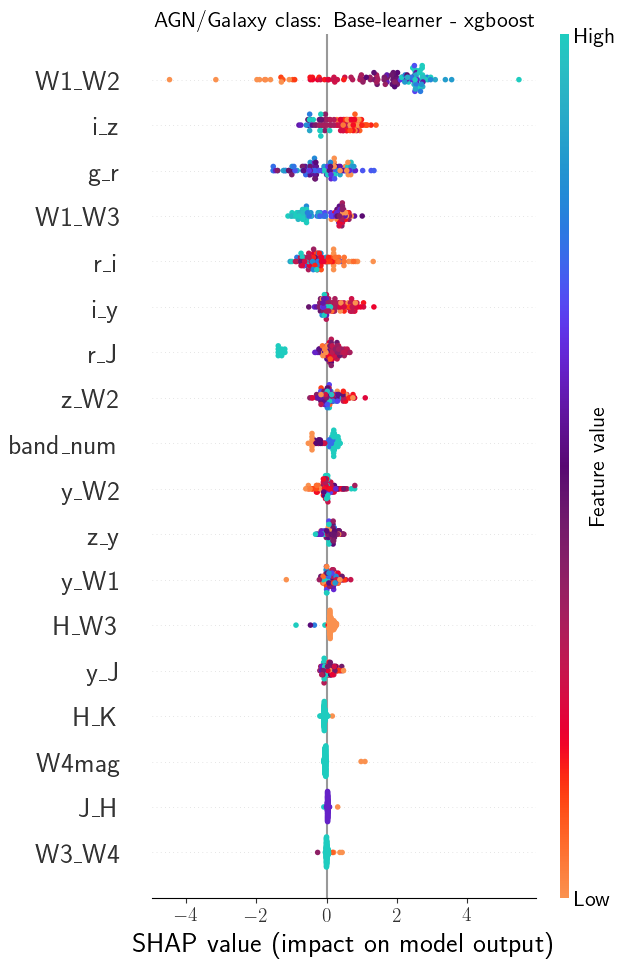

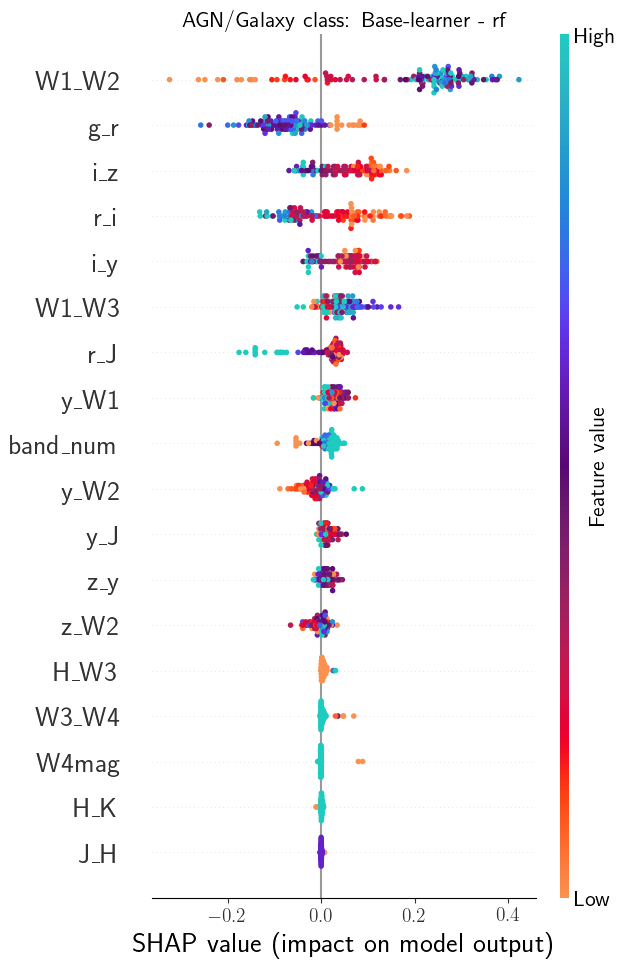

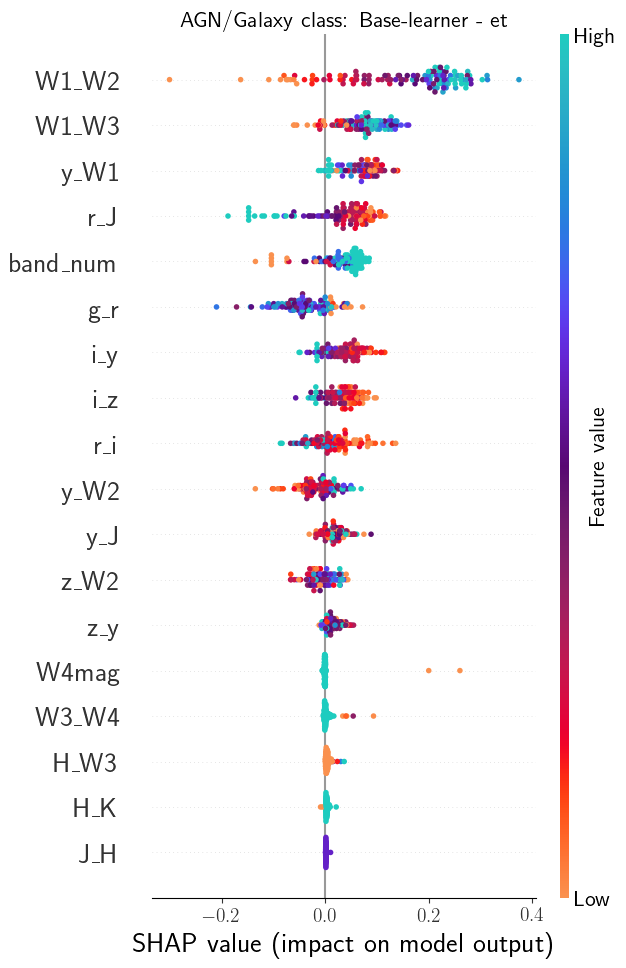

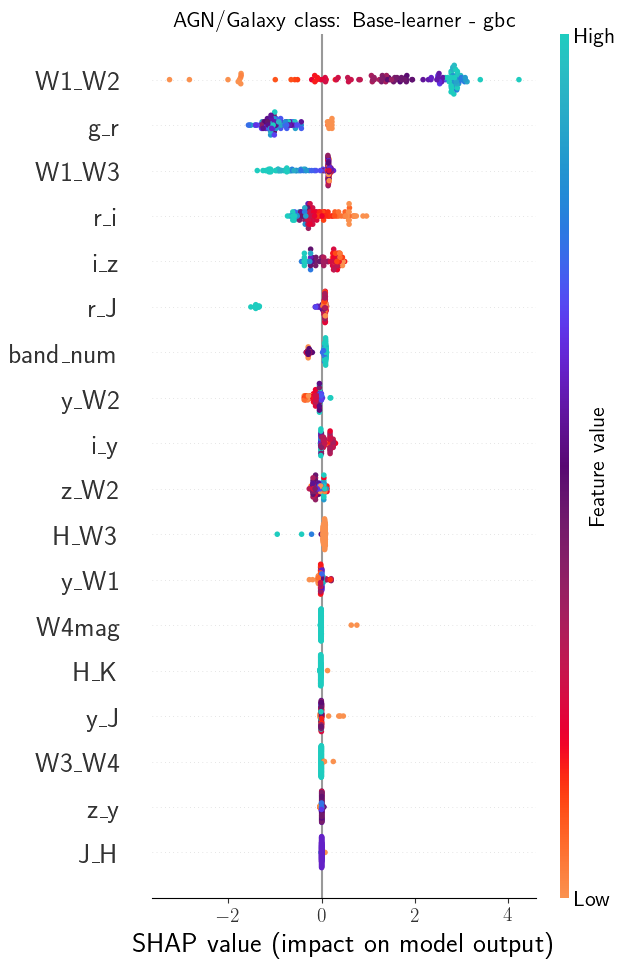

In [35]:
if run_shap_AGN_base:
    for model in shap_values_AGN_base.keys():
        gf.plot_shap_beeswarm('AGN/Galaxy class', model, shap_values_AGN_base[model], base_meta='Base')
        if save_plot_flag:
            plt.savefig(gv.plots_path + f'SHAP_AGN_base_{model}_{used_area}{subset_str}{high_z_str}.pdf', bbox_inches='tight')
        plt.show()

In [36]:
# new_base_logit_AGN = np.log(gv.cal_AGN_thresh / (1 - gv.cal_AGN_thresh))
new_base_logit_AGN = np.log(0.5 / (1 - 0.5))

In [116]:
tmp_idx = 50  # use as [tmp_idx:tmp_idx+1]

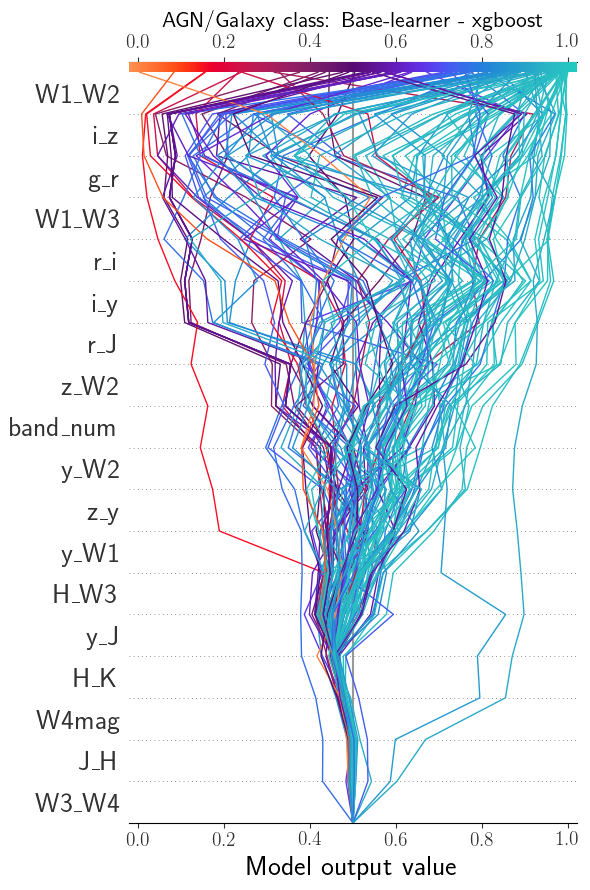

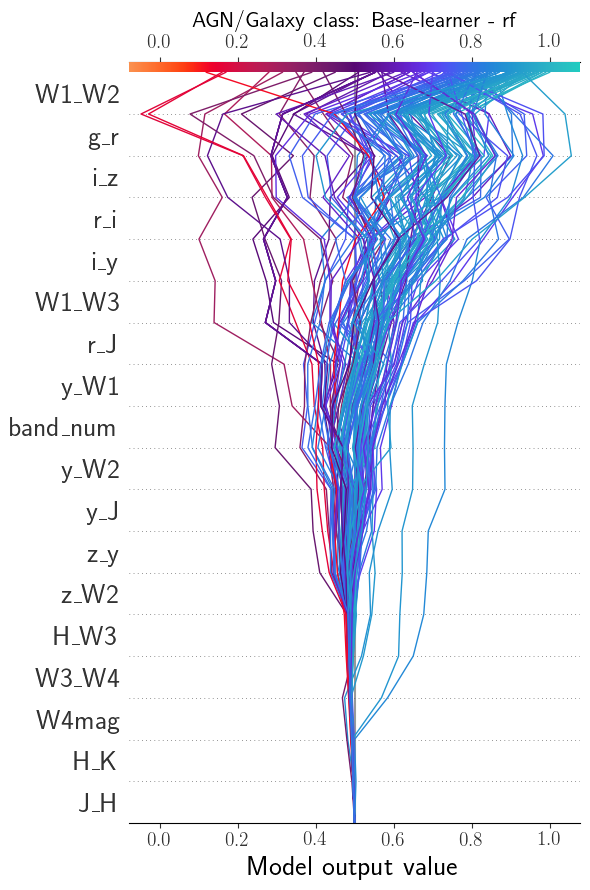

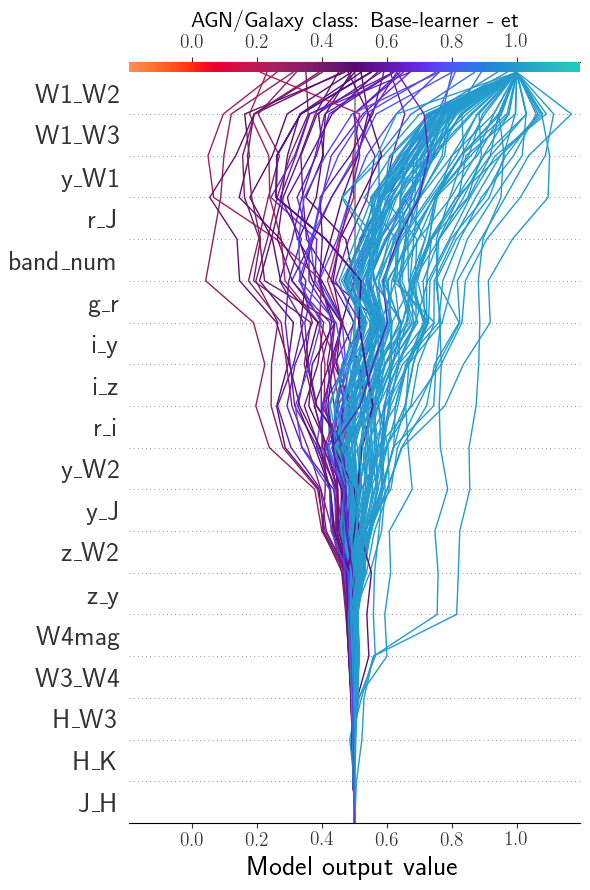

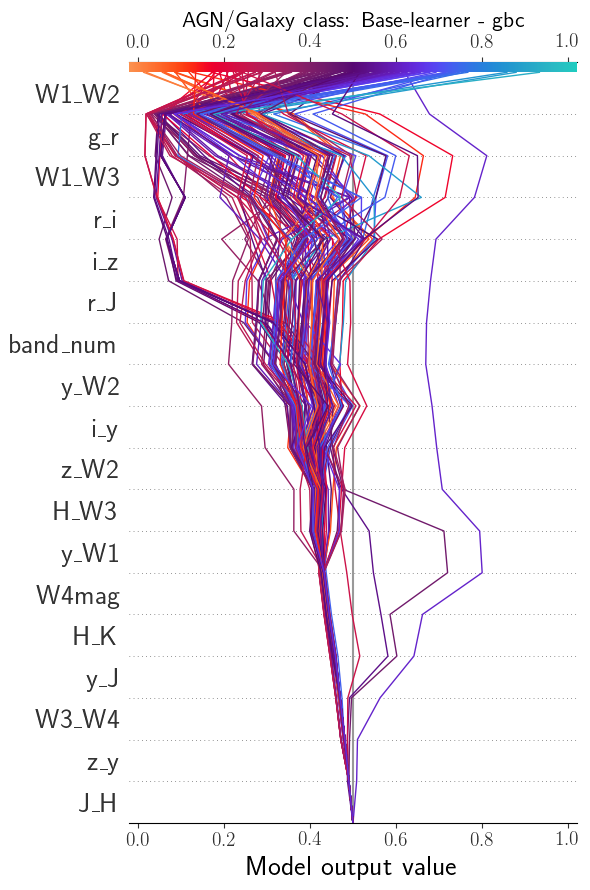

In [120]:
if run_shap_AGN_base:
    for model in shap_values_AGN_base.keys():
        size_side        = 6
        if model in ['lightgbm', 'xgboost', 'catboost', 'gbc']:
            logit_mode   = 'logit'
            new_base_AGN = new_base_logit_AGN
        else:
            logit_mode   = 'identity'
            # new_base_AGN = gv.cal_AGN_thresh
            new_base_AGN = 0.5
        fig              = plt.figure(figsize=(size_side, size_side * 3/2))
        ax1              = fig.add_subplot(111, xscale='linear', yscale='linear')
        _ = gf.plot_shap_decision('AGN/Galaxy class', model, shap_values_AGN_base[model], explainers_AGN_base[model],\
                           reduced_cols_AGN, ax1, logit_mode, new_base_value=new_base_AGN, base_meta='Base')
        if save_plot_flag:
            plt.savefig(gv.plots_path + f'SHAP_decision_AGN_base_{model}_{used_area}{subset_str}{high_z_str}_example.pdf', bbox_inches='tight')
        #plt.savefig(gv.plots_path + f'SHAP_decision_AGN_base_{model}_{used_area}{subset_str}{high_z_str}_example_large.pdf', bbox_inches='tight')
        plt.show()

In [38]:
if run_shap_AGN_base:
    sorted_mean_abs_SHAP_AGN = gf.mean_abs_SHAP_base_models(shap_values_AGN_base, list(shap_values_AGN_base.keys()))
    for key in shap_values_AGN_base.keys():
        sorted_mean_abs_SHAP_AGN[key].loc[:, 'Mean_abs_SHAP'] = sorted_mean_abs_SHAP_AGN[key].loc[:, 'Mean_abs_SHAP'] /\
                                                                sorted_mean_abs_SHAP_AGN[key].loc[:, 'Mean_abs_SHAP'].sum() * 100
    multicol_feat_AGN = [(key, name) for key in sorted_mean_abs_SHAP_AGN.keys() for name in ('Feature', 'Mean_abs_SHAP')]

In [39]:
if run_shap_AGN_base:
    sorted_mean_abs_SHAP_AGN_base_full_df = pd.concat([sorted_mean_abs_SHAP_AGN[key].reset_index(drop=True) for key in shap_values_AGN_base.keys()], axis=1)
    sorted_mean_abs_SHAP_AGN_base_full_df.columns = pd.MultiIndex.from_tuples(multicol_feat_AGN)
    print('Mean absolute SHAP values scaled to sum 100')
    with pd.option_context('display.float_format', '{:.3f}'.format):
        display(sorted_mean_abs_SHAP_AGN_base_full_df)

Mean absolute SHAP values scaled to sum 100


xgboost                      rf                      et                \
     Feature Mean_abs_SHAP   Feature Mean_abs_SHAP   Feature Mean_abs_SHAP   
0      W1_W2        31.805     W1_W2        31.525     W1_W2        24.672   
1        i_z         8.983       g_r        11.437     W1_W3        11.036   
2        g_r         8.815       i_z         9.896      y_W1         9.642   
3      W1_W3         8.169       r_i         9.797       r_J         9.027   
4        r_i         6.752       i_y         7.682  band_num         6.882   
5        i_y         5.988     W1_W3         6.352       g_r         6.723   
6        r_J         5.352       r_J         5.695       i_y         6.377   
7       z_W2         3.993      y_W1         4.077       i_z         5.512   
8   band_num         3.646  band_num         3.166       r_i         5.054   
9       y_W2         3.000      y_W2         2.631      y_W2         4.096   
10       z_y         2.938       y_J         1.995       y_J         3.116   
11      y_W1         2.871       z_y         1.944      z_W2         2.936   
12      H_W3         2.533      z_W2         1.817       z_y         2.307   
13       y_J         2.217      H_W3         0.691     W4mag         0.746   
14       H_K         1.074     W3_W4         0.633     W3_W4         0.684   
15     W4mag         0.851     W4mag         0.321      H_W3         0.599   
16       J_H         0.612       H_K         0.238       H_K         0.429   
17     W3_W4         0.400       J_H         0.104       J_H         0.161   

         gbc                
     Feature Mean_abs_SHAP  
0      W1_W2        41.370  
1        g_r        19.139  
2      W1_W3         8.750  
3        r_i         7.314  
4        i_z         5.730  
5        r_J         4.412  
6   band_num         2.663  
7       y_W2         2.562  
8        i_y         2.132  
9       z_W2         2.070  
10      H_W3         1.475  
11      y_W1         0.808  
12     W4mag         0.404  
13       H_K         0.401  
14       y_J         0.395  
15     W3_W4         0.175  
16       z_y         0.134  
17       J_H         0.065

In [40]:
if run_shap_AGN_base:
    sorted_mean_abs_SHAP_AGN = pd.read_hdf(gv.tmp_shap_path + f'mean_abs_SHAP_AGN_meta_{used_area}{subset_str}{high_z_str}.h5', key='df')

In [41]:
if run_shap_AGN_base:
    print('Combined mean absolute SHAP values scaled to sum 100')
    sorted_mean_abs_SHAP_AGN_comb = sorted_mean_abs_SHAP_AGN.copy().set_index('Feature')
    for key in shap_values_AGN_base.keys():
        factor = sorted_mean_abs_SHAP_AGN.set_index('Feature').loc[key] / 100
        tmp_feat_imp = sorted_mean_abs_SHAP_AGN_base_full_df.loc[:, key].copy().set_index('Feature')
        sorted_mean_abs_SHAP_AGN_comb = sorted_mean_abs_SHAP_AGN_comb + tmp_feat_imp * factor
    sorted_mean_abs_SHAP_AGN_comb = sorted_mean_abs_SHAP_AGN_comb.sort_values(by=['Mean_abs_SHAP'],
                                                                              ascending=False).drop(index=list(shap_values_AGN_base.keys()))
    sorted_mean_abs_SHAP_AGN_comb['Cumulative_sum'] = sorted_mean_abs_SHAP_AGN_comb.loc[:, 'Mean_abs_SHAP'].cumsum()
    with pd.option_context('display.float_format', '{:.3f}'.format):
        display(sorted_mean_abs_SHAP_AGN_comb)

Combined mean absolute SHAP values scaled to sum 100


Mean_abs_SHAP  Cumulative_sum
Feature                                
W1_W2            32.458          32.458
g_r              12.583          45.041
W1_W3             8.816          53.857
r_i               7.457          61.314
i_z               6.741          68.055
r_J               6.613          74.667
i_y               5.086          79.754
y_W1              4.639          84.393
band_num          4.050          88.442
y_W2              3.228          91.670
z_W2              2.348          94.018
y_J               1.718          95.737
z_y               1.591          97.328
H_W3              1.048          98.376
W4mag             0.514          98.890
H_K               0.466          99.356
W3_W4             0.466          99.822
J_H               0.178         100.000

xgboost


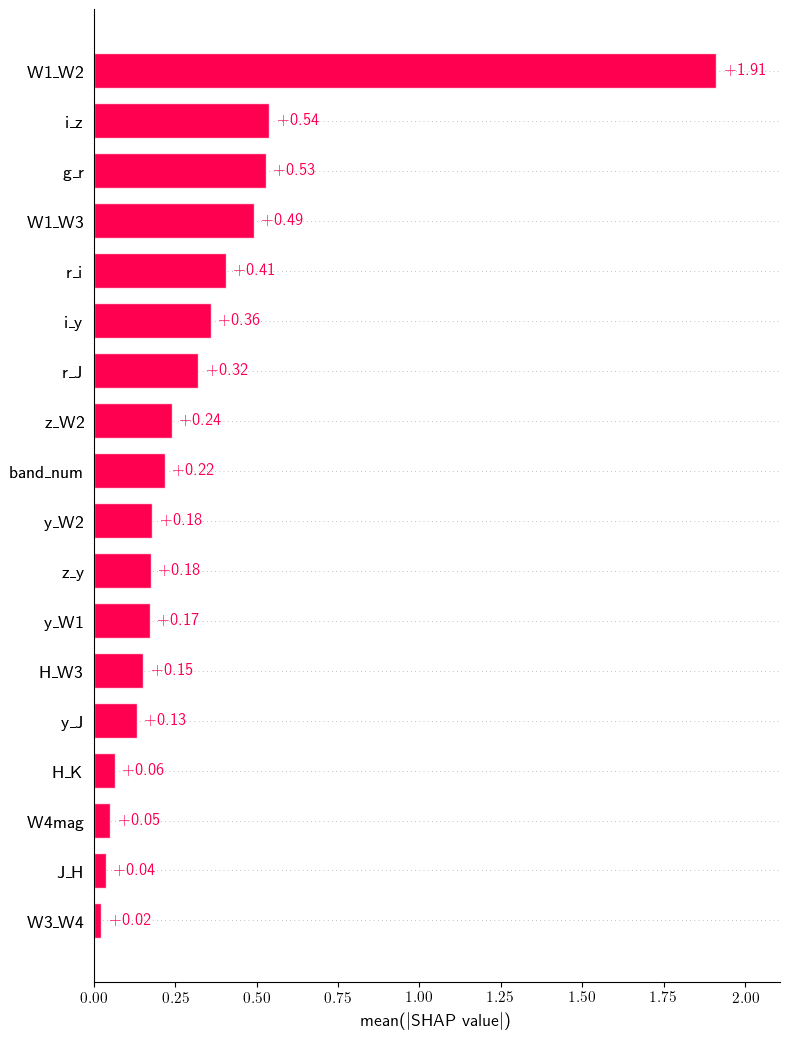

rf


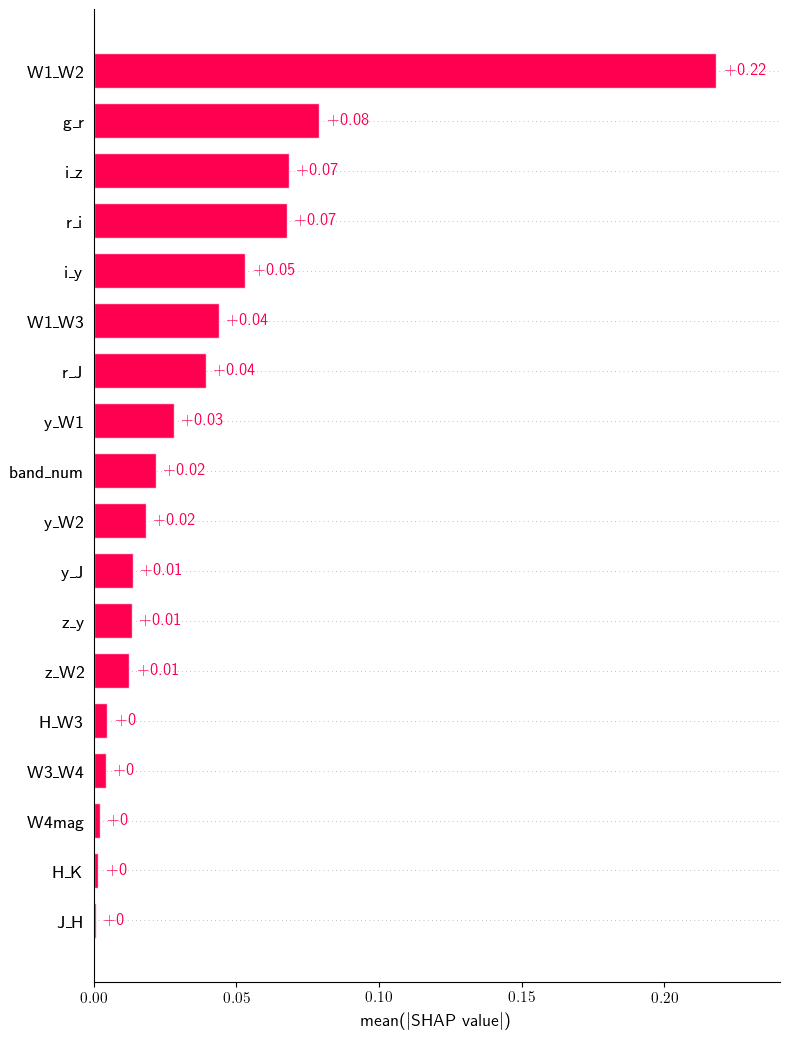

et


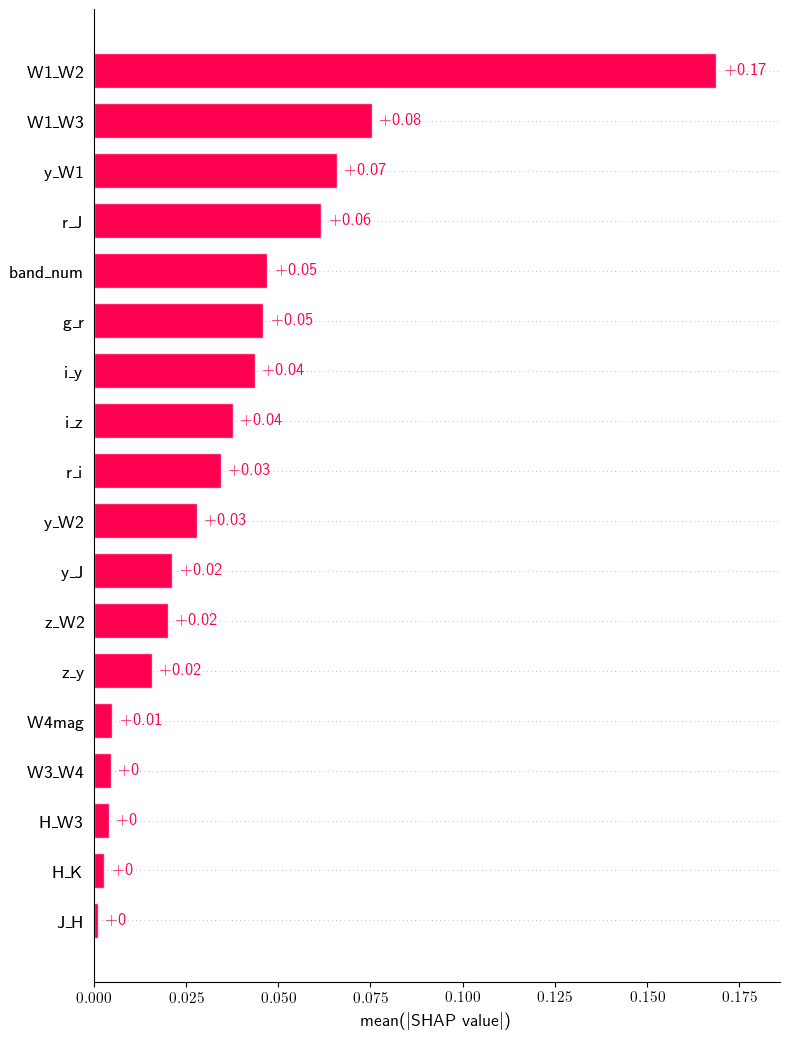

gbc


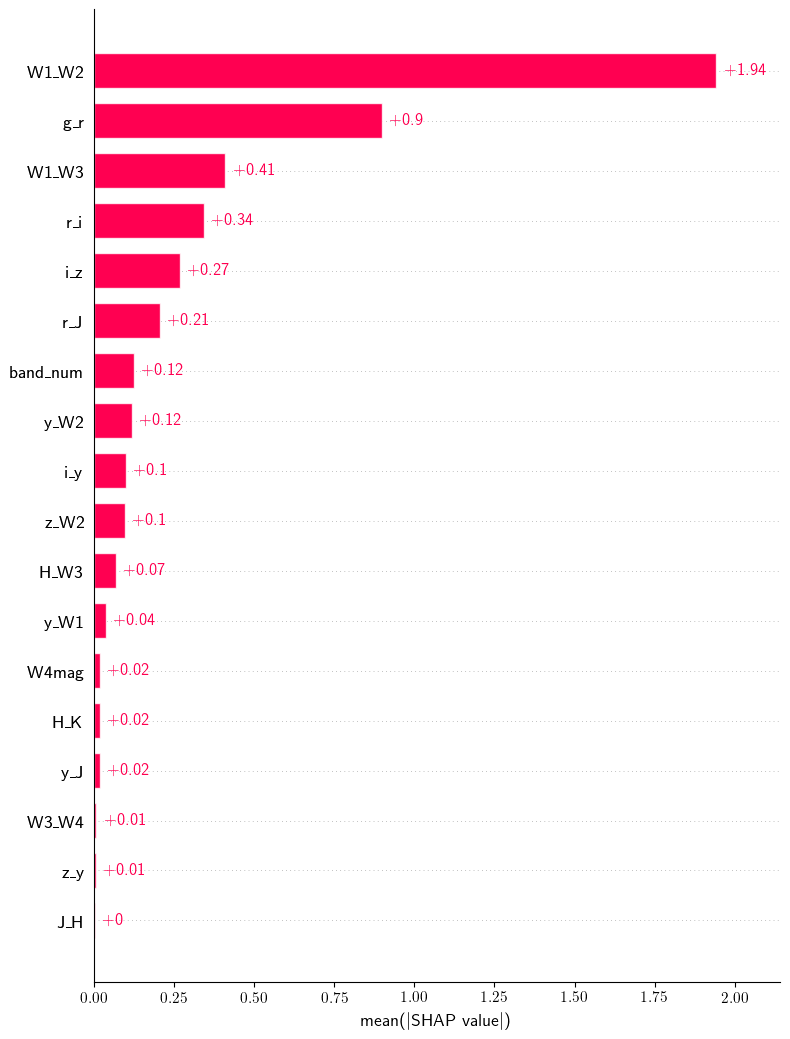

In [42]:
if run_shap_AGN_base:
    shp_copies_AGN = {}
    for model in shap_values_AGN_base.keys():
        # Convert from FastTreeShap to Shap object
        shp_copies_AGN[model] = shap.Explanation(values=shap_values_AGN_base[model].values,\
                                                 base_values=shap_values_AGN_base[model].base_values,\
                                                 data=shap_values_AGN_base[model].data,\
                                                 feature_names=shap_values_AGN_base[model].feature_names)
        print(f'{model}')
        if np.ndim(shp_copies_AGN[model].values) == 2:
            shap.plots.bar(shap_values=shp_copies_AGN[model], max_display=None, show=False)
        elif np.ndim(shp_copies_AGN[model].values) > 2:
            shap.plots.bar(shap_values=shp_copies_AGN[model][:, :, 1], max_display=None, show=False)
        plt.gca().set_xlabel('mean($\\vert$SHAP value$\\vert$)')
        plt.tight_layout()
        plt.show()

xgboost


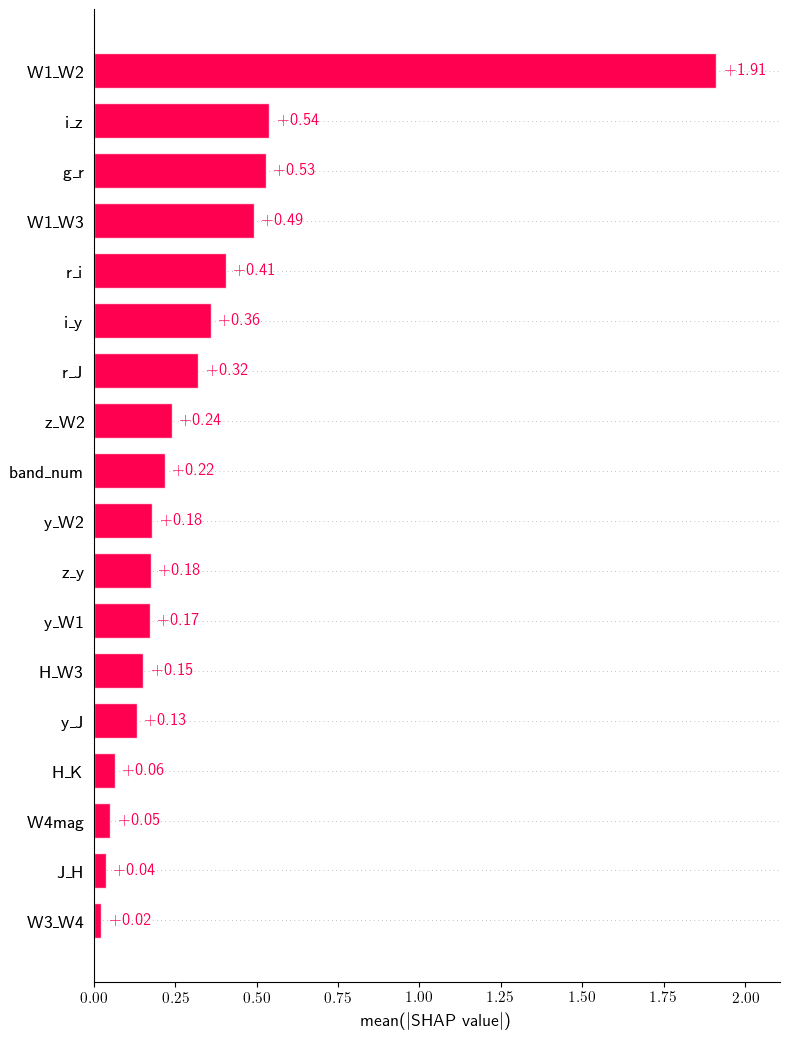

rf


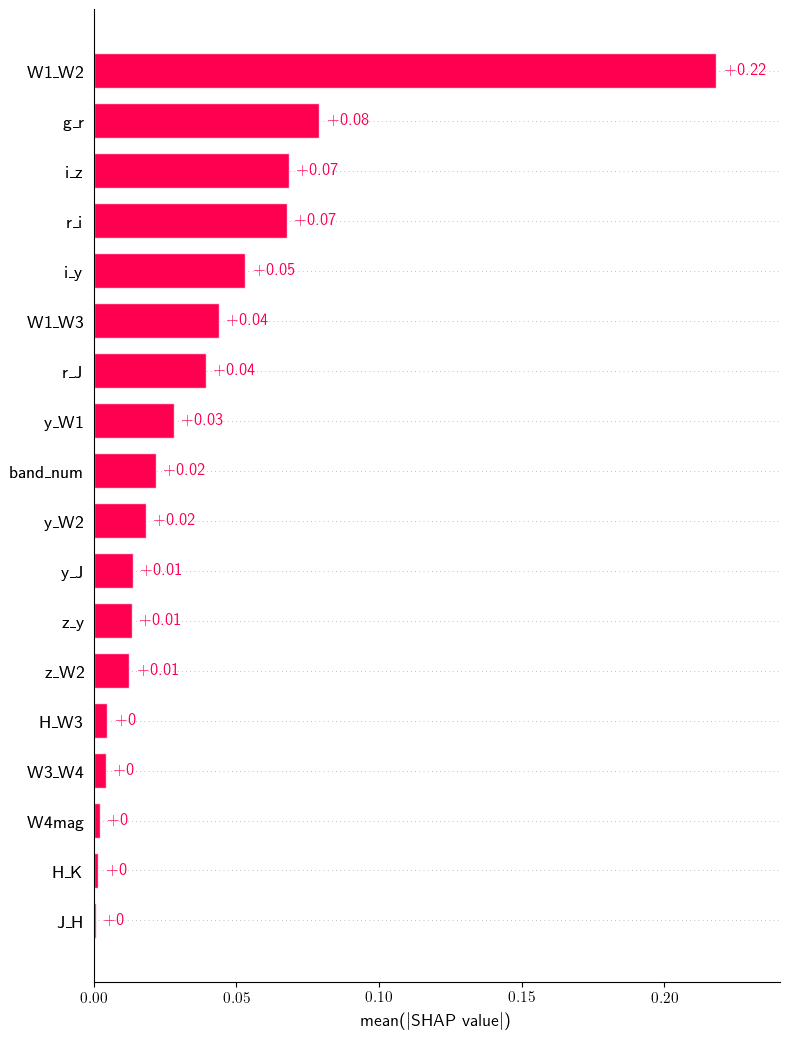

et


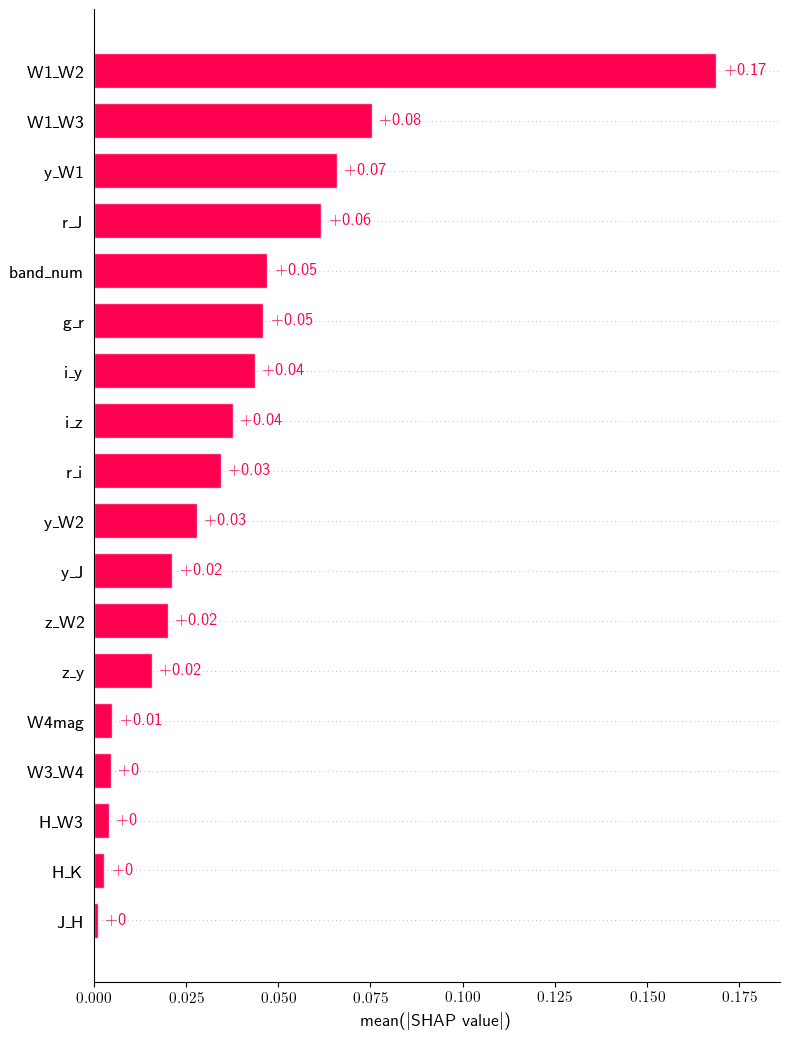

gbc


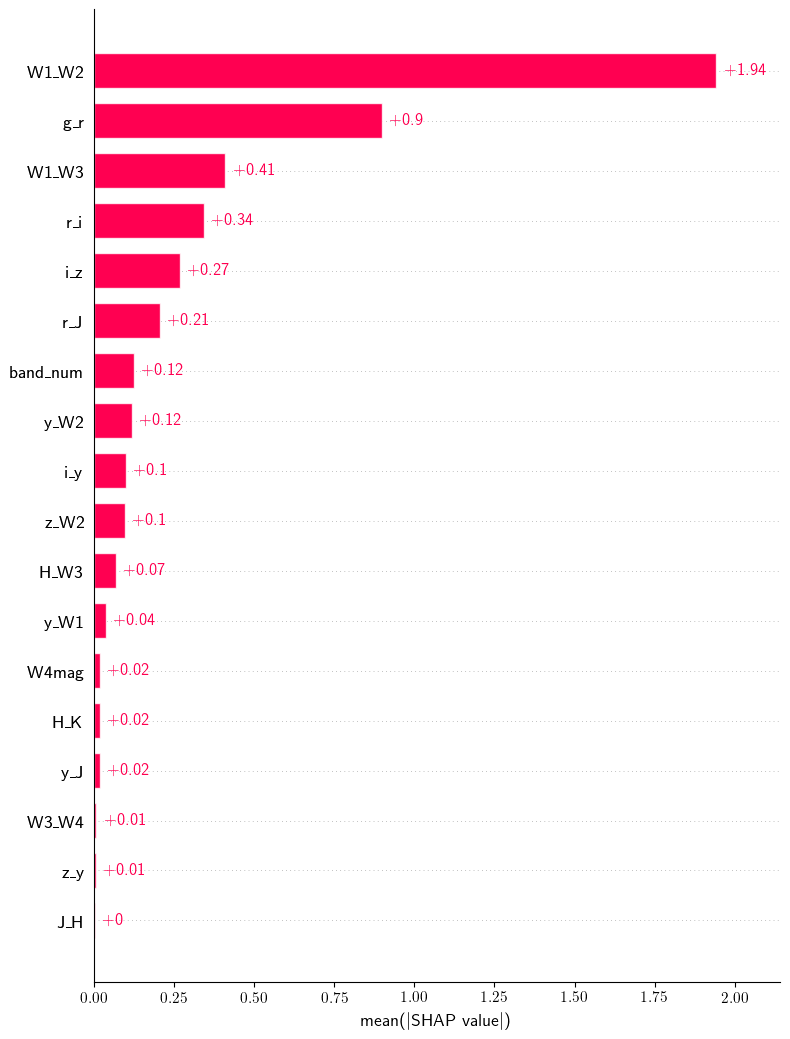

In [43]:
if run_shap_AGN_base:
    class_AGN_labels = ['Galaxy' if elem == 0 else 'AGN' for elem in reduced_data_AGN.loc[:, 'class']]
    for model in shap_values_AGN_base.keys():
        print(f'{model}')
        if np.ndim(shp_copies_AGN[model].values) == 2:
            shap.plots.bar(shap_values=shp_copies_AGN[model].cohorts(class_AGN_labels).abs.mean(0), max_display=None, show=False)
        elif np.ndim(shp_copies_AGN[model].values) > 2:
            shap.plots.bar(shap_values=shp_copies_AGN[model][:, :, 1].cohorts(class_AGN_labels).abs.mean(0), max_display=None, show=False)
        plt.gca().set_xlabel('mean($\\vert$SHAP value$\\vert$)')
        plt.tight_layout()
        plt.show()

In [44]:
if run_shap_AGN_base:
    for count, model in enumerate(shap_values_AGN_base.keys()):
        print(f'\n{model}:')
        # The model's raw prediction for the first observation.
        print(AGN_gal_clf.named_steps['trained_model'].estimators_[count].predict(reduced_data_AGN_df.drop(columns=base_models_names_AGN))[0].round(5))
    
        # The corresponding sum of the mean + shap values
        print((np.array([explainers_AGN_base[model].expected_value]).flatten()[-1] + shap_values_AGN_base[model].values[0].sum()).round(5))


xgboost:
1
3.42494

rf:
1
0.42604

et:
1
0.42564

gbc:
0
-0.01198


---

#### SHAP - Radio detection model

In [45]:
if run_shap_radio_base:
    model_name_radio = type(radio_det_clf.named_steps['trained_model'].final_estimator_).__name__.replace('Classifier', '')

SHAP does not need to use the full dataset for its analysis. Around $N=1000$ is a good number.

In [46]:
if run_shap_radio_base:
    sample_size_radio   = 1000
    if not use_high_z_sources:
        filter_pred_AGN = np.array(full_catalog_df.loc[:, 'pred_class'] == 1) & filter_pred_no_str
    if use_high_z_sources:
        filter_pred_AGN   = np.ones_like(full_catalog_df.loc[:, 'class']).astype(bool)
    sample_size_radio   = np.nanmin([sample_size_radio, np.sum(filter_pred_AGN)])
    print(f'Number of selected elements: {sample_size_radio:,}')

Number of selected elements: 121


In [47]:
if run_shap_radio_base:
    base_models_name_radio   = gf.get_base_estimators_names(radio_det_clf)

In [48]:
if run_shap_radio_base:
    reduced_data_radio    = full_catalog_df.loc[filter_pred_AGN].sample(n=sample_size_radio, random_state=gv.seed).copy()
    display(reduced_data_radio.loc[:, ['LOFAR_detect', 'pred_radio']].describe())
    reduced_data_radio_df = gf.preprocess_data(radio_det_clf, reduced_data_radio, base_models_name_radio)
    reduced_cols_radio    = reduced_data_radio_df.columns.drop(base_models_name_radio)

LOFAR_detect  pred_radio
count    121.000000       121.0
mean       0.239669         0.0
std        0.428657         0.0
min        0.000000         0.0
25%        0.000000         0.0
50%        0.000000         0.0
75%        0.000000         0.0
max        1.000000         0.0

Use FastTreeSHAP package

In [49]:
if run_shap_radio_base:
    explainers_radio_base           = {}
    for model, model_fit in zip(radio_det_clf.named_steps['trained_model'].estimators, radio_det_clf.named_steps['trained_model'].estimators_):
        explainers_radio_base[model[0]] = fasttreeshap.TreeExplainer(model_fit, data=None, feature_perturbation='tree_path_dependent',\
                                                                     model_output='raw', feature_dependence='independent', algorithm='auto',
                                                                     n_jobs=12)

In [50]:
if run_shap_radio_base:
    shap_values_radio_base = {}
    for model in explainers_radio_base.keys():
        print(f'Working with base model {model}')
        shap_values_radio_base[model] = explainers_radio_base[model](reduced_data_radio_df.drop(columns=base_models_name_radio))

Working with base model xgboost
Working with base model catboost
Working with base model rf
Working with base model et


In [51]:
if run_shap_radio_base:
    print('Expected "logit" values per base model')
    print('-' * 30)
    for model in explainers_radio_base.keys():
        expected_value = np.array([explainers_radio_base[model].expected_value]).flatten()[-1]
        if model in ['lightgbm', 'xgboost', 'catboost', 'gbc']:
            print(f'{model: <10}\t: {np.exp(expected_value) / (1 + np.exp(expected_value)): .4f}')
        else:
            print(f'{model: <10}\t: {expected_value: .4f}')

Expected "logit" values per base model
------------------------------
xgboost   	:  0.1026
catboost  	:  0.0757
rf        	:  0.1265
et        	:  0.1265


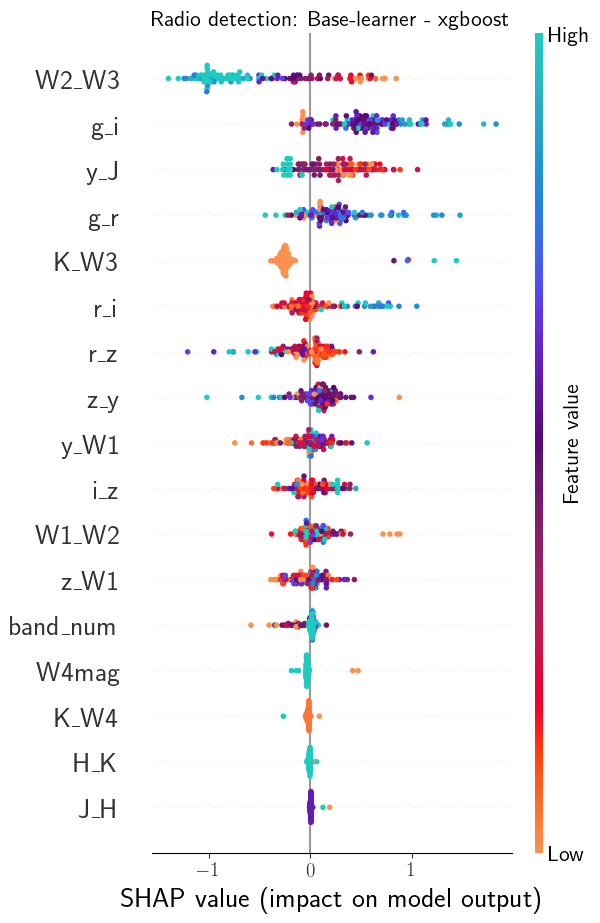

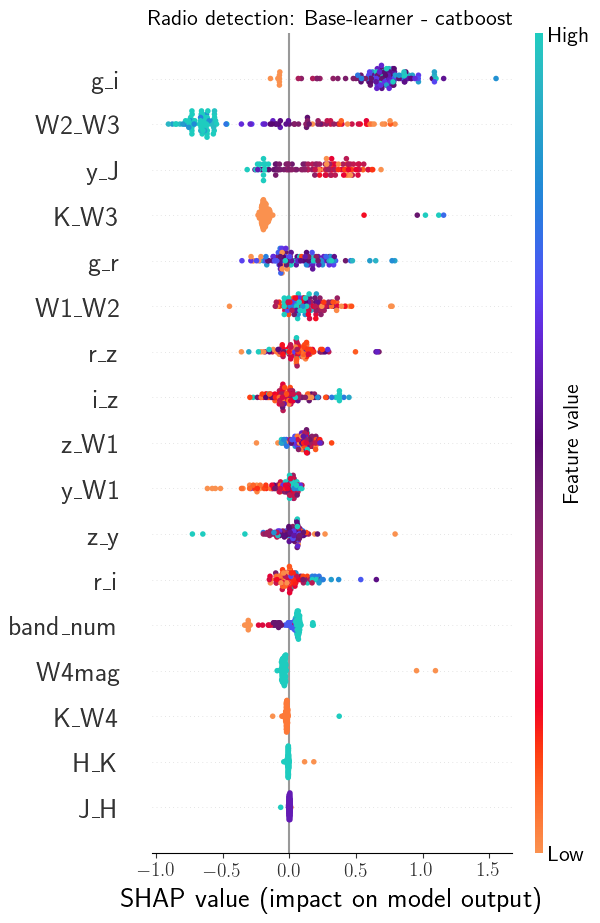

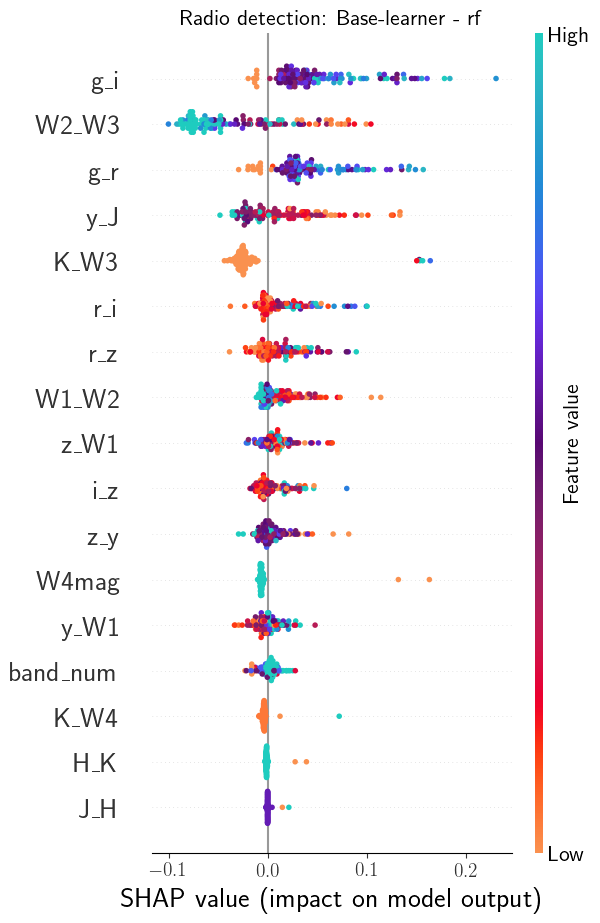

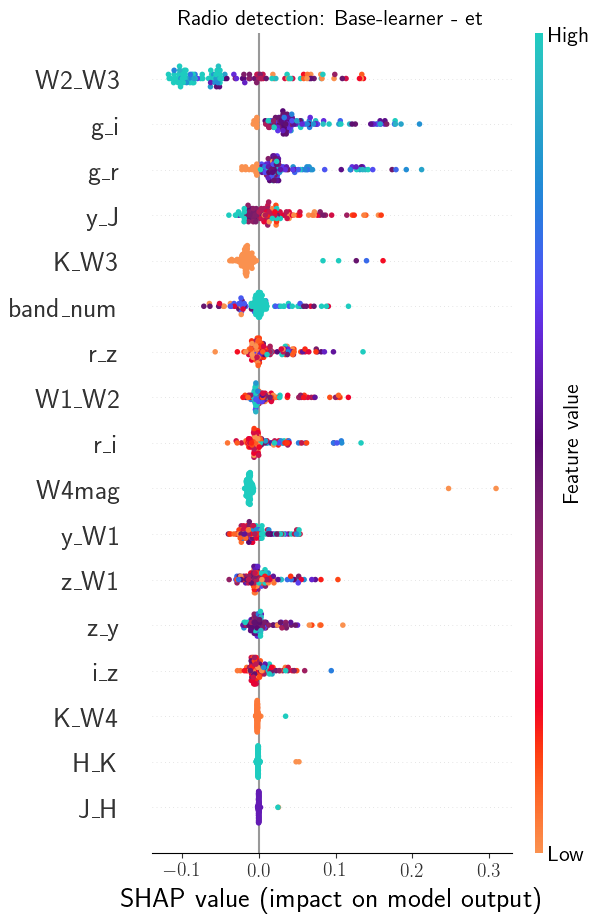

In [52]:
if run_shap_radio_base:
    for model in shap_values_radio_base.keys():
        gf.plot_shap_beeswarm('Radio detection', model, shap_values_radio_base[model], base_meta='Base')
        if save_plot_flag:
            plt.savefig(gv.plots_path + f'SHAP_radio_base_{model}_{used_area}{subset_str}{high_z_str}.pdf', bbox_inches='tight')
        plt.show()

In [53]:
# new_base_logit_radio = np.log(gv.radio_thresh / (1 - gv.radio_thresh))
new_base_logit_radio = np.log(0.5 / (1 - 0.5))

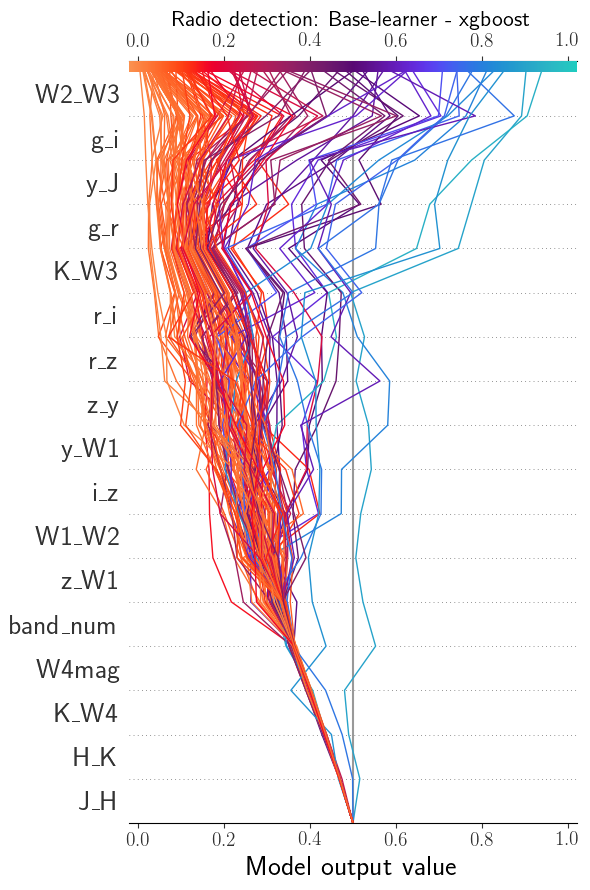

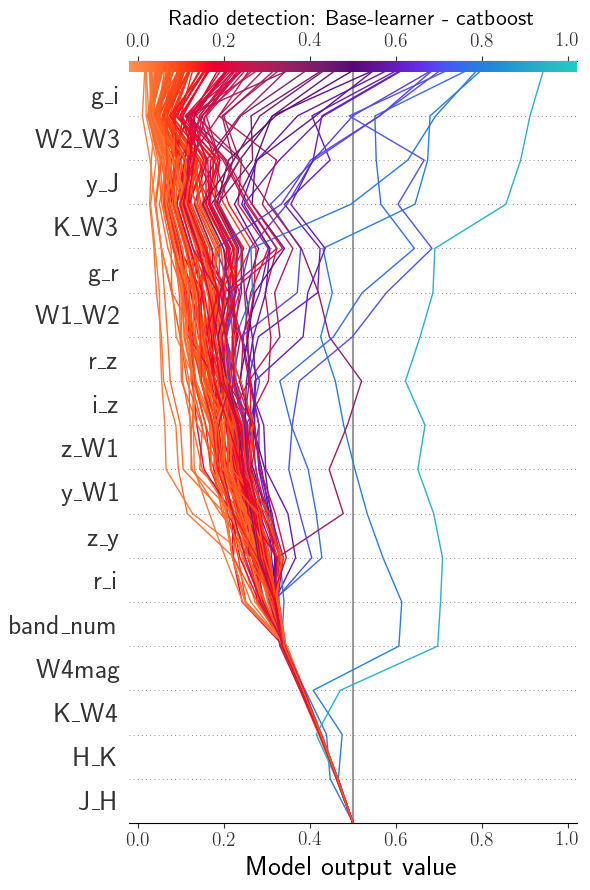

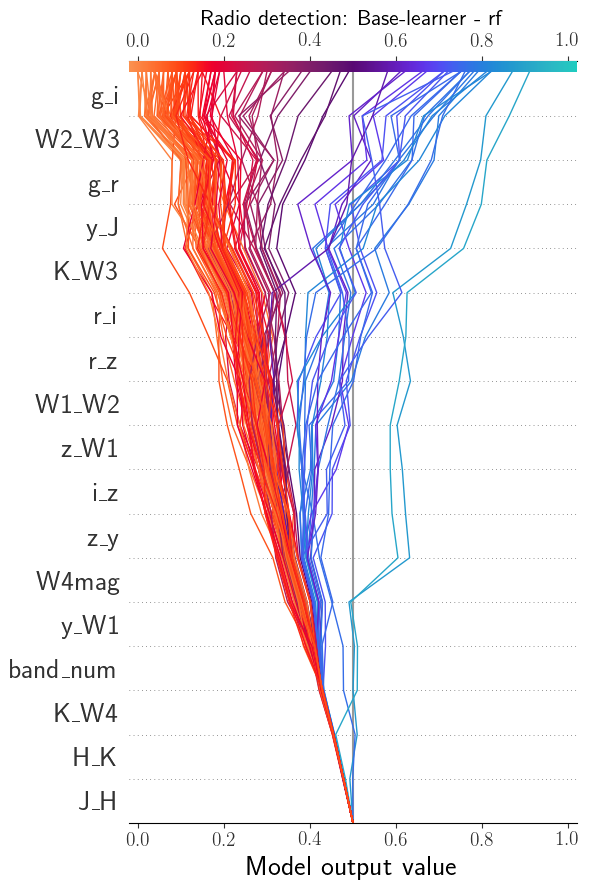

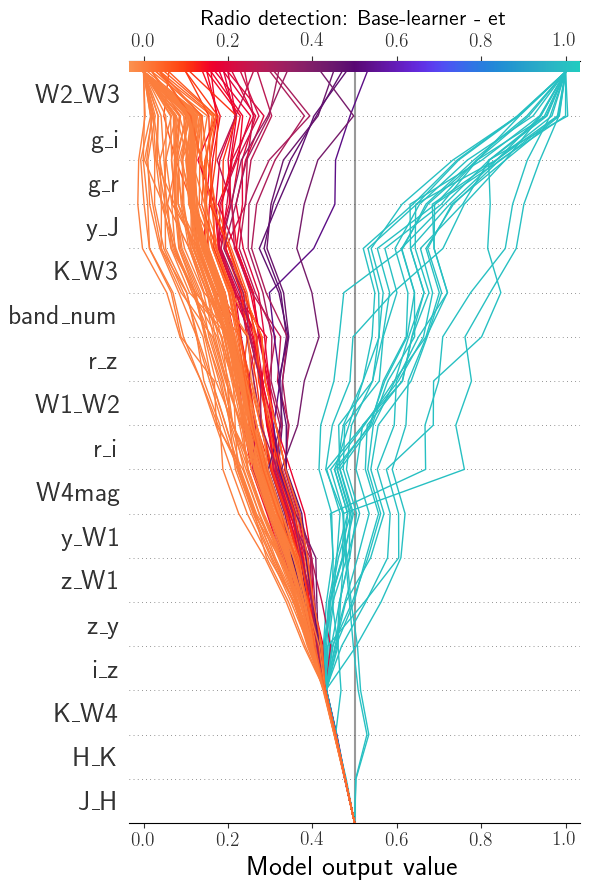

In [54]:
if run_shap_radio_base:
    for model in shap_values_radio_base.keys():
        size_side          = 6
        if model in ['lightgbm', 'xgboost', 'catboost', 'gbc']:
            logit_mode     = 'logit'
            new_base_radio = new_base_logit_radio
        else:
            logit_mode     = 'identity'
            # new_base_radio = gv.radio_thresh
            new_base_radio = 0.5
        fig                = plt.figure(figsize=(size_side, size_side * 3/2))
        ax1                = fig.add_subplot(111, xscale='linear', yscale='linear')
        _ = gf.plot_shap_decision('Radio detection', model, shap_values_radio_base[model], explainers_radio_base[model],\
                                  reduced_cols_radio, ax1, logit_mode, new_base_value=new_base_radio, base_meta='Base')
        if save_plot_flag:
            plt.savefig(gv.plots_path + f'SHAP_decision_radio_base_{model}_{used_area}{subset_str}{high_z_str}.pdf', bbox_inches='tight')
        plt.show()

In [55]:
if run_shap_radio_base:
    sorted_mean_abs_SHAP_radio = gf.mean_abs_SHAP_base_models(shap_values_radio_base, list(shap_values_radio_base.keys()))
    for key in shap_values_radio_base.keys():
        sorted_mean_abs_SHAP_radio[key].loc[:, 'Mean_abs_SHAP'] = sorted_mean_abs_SHAP_radio[key].loc[:, 'Mean_abs_SHAP'] /\
                                                                  sorted_mean_abs_SHAP_radio[key].loc[:, 'Mean_abs_SHAP'].sum() * 100
    multicol_feat_radio = [(key, name) for key in sorted_mean_abs_SHAP_radio.keys() for name in ('Feature', 'Mean_abs_SHAP')]

In [56]:
if run_shap_radio_base:
    sorted_mean_abs_SHAP_radio_base_full_df = pd.concat([sorted_mean_abs_SHAP_radio[key].reset_index(drop=True) for key in shap_values_radio_base.keys()], axis=1)
    sorted_mean_abs_SHAP_radio_base_full_df.columns = pd.MultiIndex.from_tuples(multicol_feat_radio)
    print('Mean absolute SHAP values scaled to sum 100')
    with pd.option_context('display.float_format', '{:.3f}'.format):
        display(sorted_mean_abs_SHAP_radio_base_full_df)

Mean absolute SHAP values scaled to sum 100


xgboost                catboost                      rf                \
     Feature Mean_abs_SHAP   Feature Mean_abs_SHAP   Feature Mean_abs_SHAP   
0      W2_W3        19.585       g_i        24.335       g_i        16.722   
1        g_i        16.965     W2_W3        18.356     W2_W3        15.470   
2        y_J         9.437       y_J         9.820       g_r        13.138   
3        g_r         8.815      K_W3         7.868       y_J         9.393   
4       K_W3         8.775       g_r         5.924      K_W3         9.210   
5        r_i         5.906     W1_W2         5.630       r_i         5.607   
6        r_z         5.571       r_z         4.210       r_z         5.515   
7        z_y         4.923       i_z         3.918     W1_W2         4.836   
8       y_W1         4.357      z_W1         3.877      z_W1         3.783   
9        i_z         3.996      y_W1         3.348       i_z         3.632   
10     W1_W2         3.779       z_y         3.078       z_y         3.125   
11      z_W1         3.707       r_i         3.025     W4mag         2.670   
12  band_num         1.777  band_num         2.946      y_W1         2.659   
13     W4mag         1.259     W4mag         2.172  band_num         2.125   
14      K_W4         0.688      K_W4         0.923      K_W4         1.402   
15       H_K         0.261       H_K         0.458       H_K         0.538   
16       J_H         0.202       J_H         0.113       J_H         0.175   

          et                
     Feature Mean_abs_SHAP  
0      W2_W3        17.608  
1        g_i        15.425  
2        g_r        11.035  
3        y_J         7.848  
4       K_W3         5.765  
5   band_num         5.604  
6        r_z         5.101  
7      W1_W2         5.065  
8        r_i         4.834  
9      W4mag         4.631  
10      y_W1         4.618  
11      z_W1         4.504  
12       z_y         3.381  
13       i_z         3.137  
14      K_W4         0.663  
15       H_K         0.559  
16       J_H         0.222

In [57]:
if run_shap_radio_base:
    sorted_mean_abs_SHAP_radio = pd.read_hdf(gv.tmp_shap_path + f'mean_abs_SHAP_radio_meta_{used_area}{subset_str}{high_z_str}.h5', key='df')

In [58]:
if run_shap_radio_base:
    print('Combined mean absolute SHAP values scaled to sum 100')
    sorted_mean_abs_SHAP_radio_comb = sorted_mean_abs_SHAP_radio.copy().set_index('Feature')
    for key in shap_values_radio_base.keys():
        factor = sorted_mean_abs_SHAP_radio.set_index('Feature').loc[key] / 100
        tmp_feat_imp = sorted_mean_abs_SHAP_radio_base_full_df.loc[:, key].copy().set_index('Feature')
        sorted_mean_abs_SHAP_radio_comb = sorted_mean_abs_SHAP_radio_comb + tmp_feat_imp * factor
    sorted_mean_abs_SHAP_radio_comb = sorted_mean_abs_SHAP_radio_comb.sort_values(by=['Mean_abs_SHAP'],
                                                                                  ascending=False).drop(index=list(shap_values_radio_base.keys()))
    sorted_mean_abs_SHAP_radio_comb['Cumulative_sum'] = sorted_mean_abs_SHAP_radio_comb.loc[:, 'Mean_abs_SHAP'].cumsum()
    with pd.option_context('display.float_format', '{:.3f}'.format):
        display(sorted_mean_abs_SHAP_radio_comb)

Combined mean absolute SHAP values scaled to sum 100


Mean_abs_SHAP  Cumulative_sum
Feature                                
g_i              14.120          14.120
W2_W3            13.201          27.321
g_r              12.955          40.276
y_J               8.224          48.500
K_W3              7.441          55.941
W1_W2             6.874          62.816
z_W1              6.751          69.566
r_i               5.577          75.143
r_z               5.161          80.304
i_z               4.512          84.816
z_y               4.121          88.936
y_W1              3.864          92.801
W4mag             2.691          95.492
band_num          2.661          98.153
K_W4              0.939          99.091
H_K               0.719          99.810
J_H               0.190         100.000

xgboost


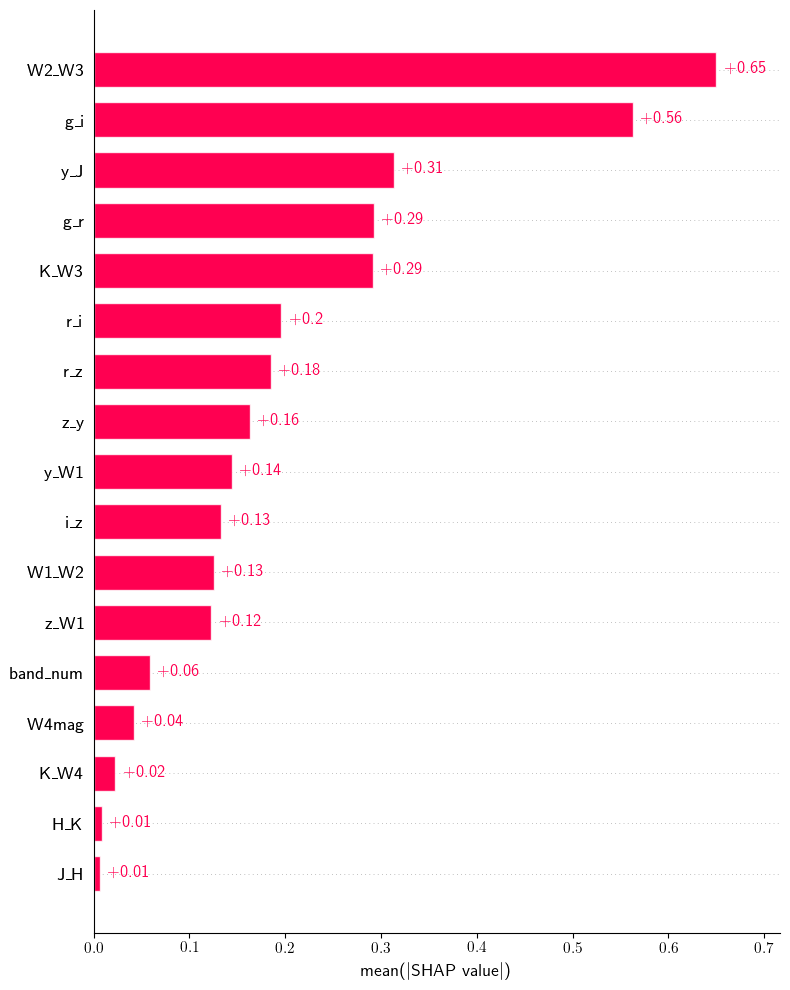

catboost


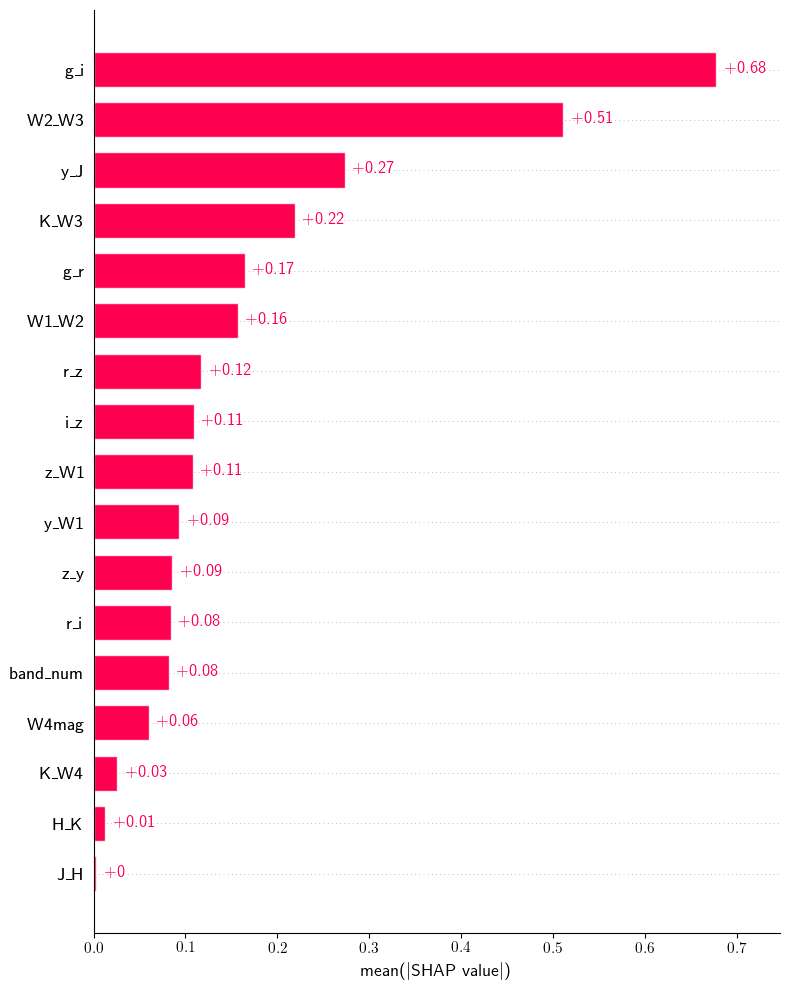

rf


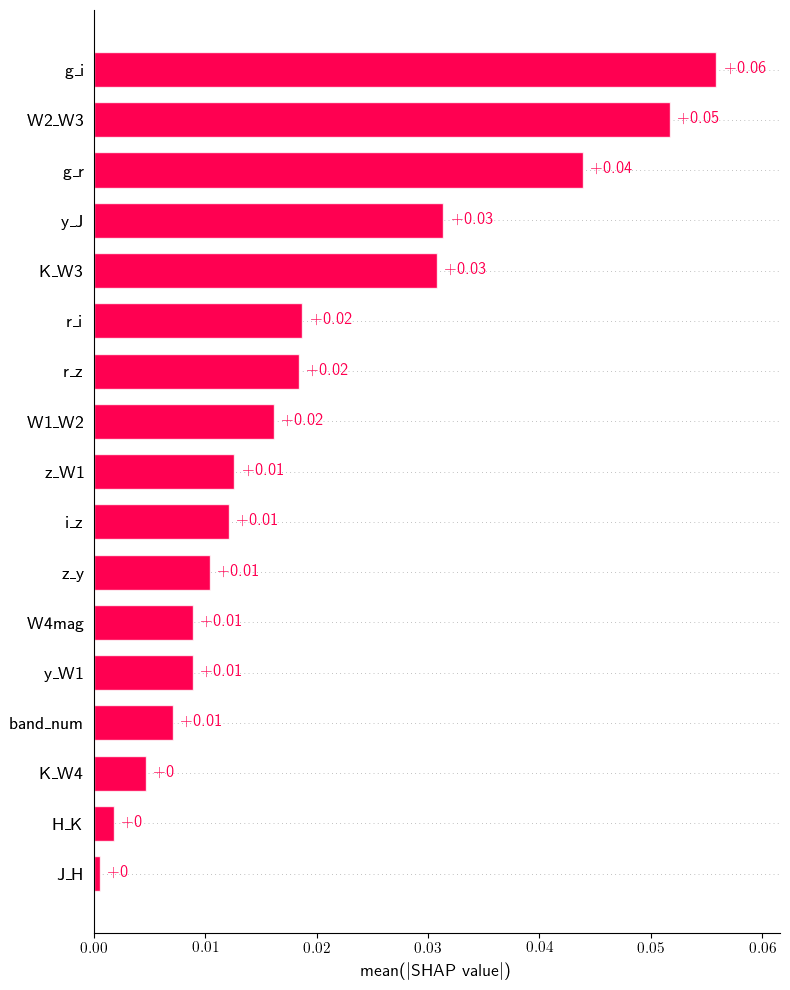

et


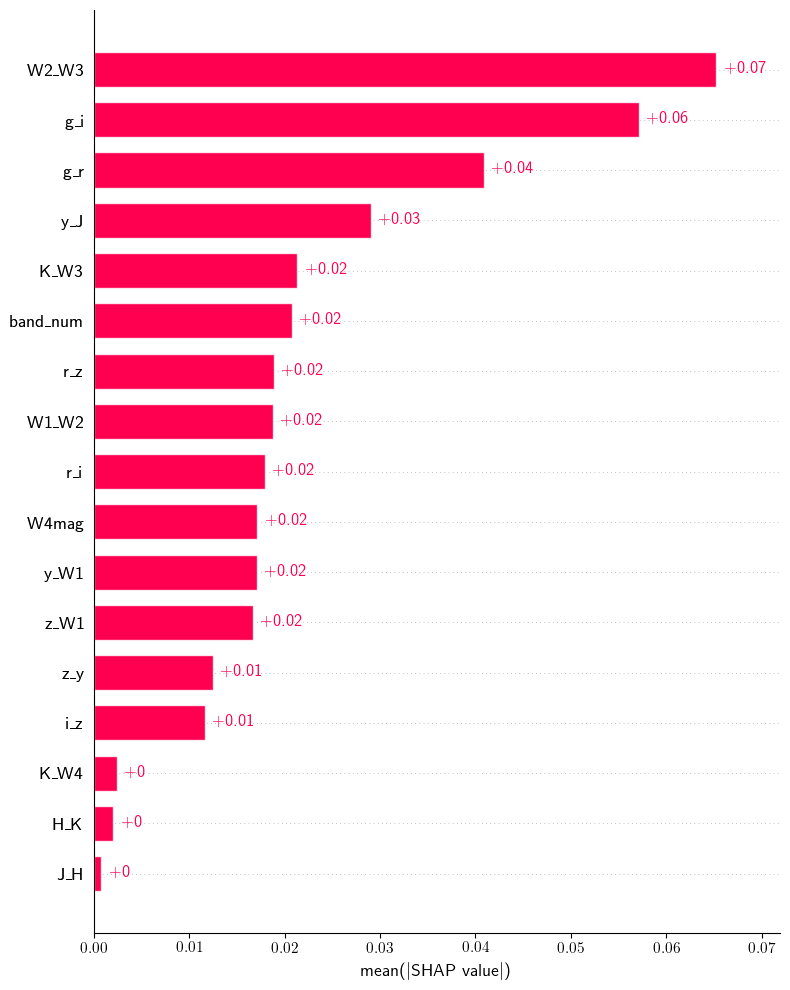

In [59]:
if run_shap_radio_base:
    shp_copies_radio = {}
    for model in shap_values_radio_base.keys():
        # Convert from FastTreeShap to Shap object
        shp_copies_radio[model] = shap.Explanation(values=shap_values_radio_base[model].values,\
                                                 base_values=shap_values_radio_base[model].base_values,\
                                                 data=shap_values_radio_base[model].data,\
                                                 feature_names=shap_values_radio_base[model].feature_names)
        print(f'{model}')
        if np.ndim(shp_copies_radio[model].values) == 2:
            shap.plots.bar(shap_values=shp_copies_radio[model], max_display=None, show=False)
        elif np.ndim(shp_copies_radio[model].values) > 2:
            shap.plots.bar(shap_values=shp_copies_radio[model][:, :, 1], max_display=None, show=False)
        plt.gca().set_xlabel('mean($\\vert$SHAP value$\\vert$)')
        plt.tight_layout()
        plt.show()

xgboost


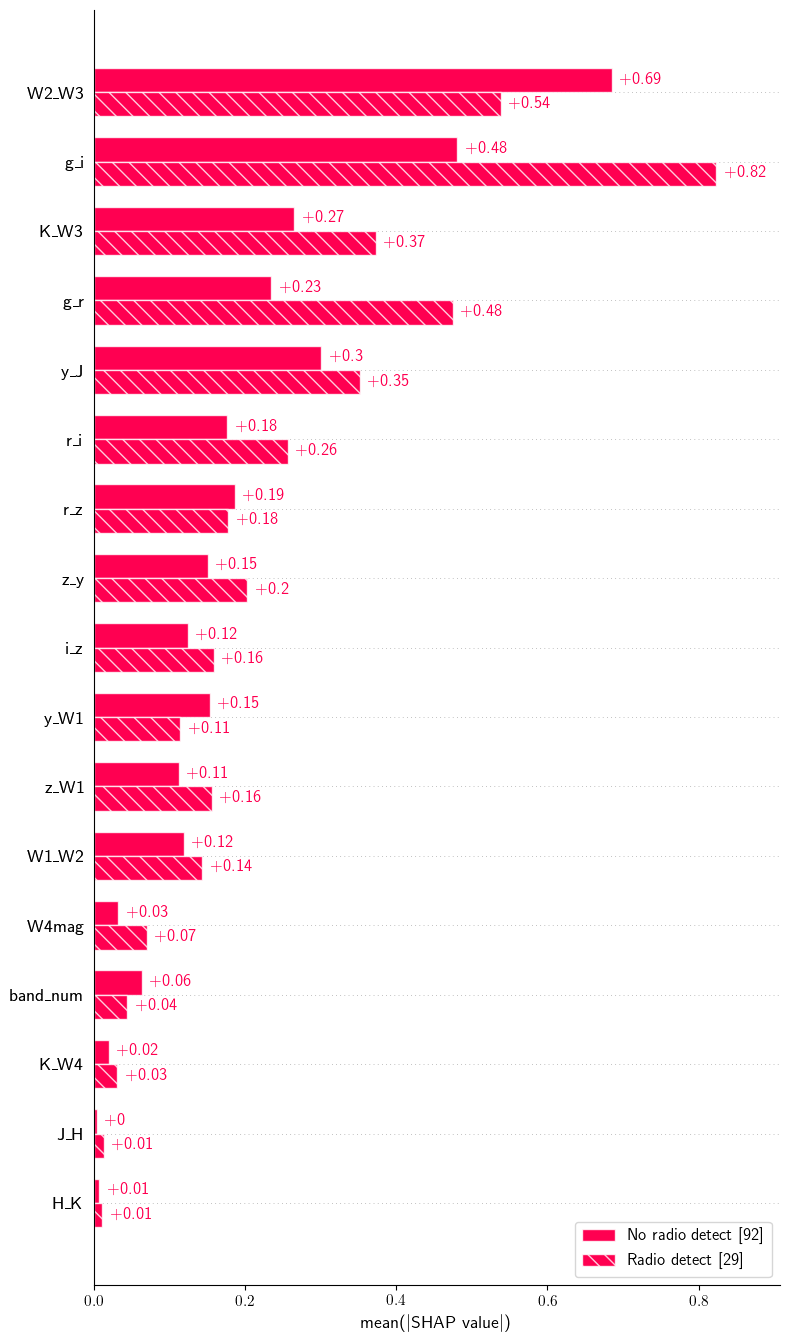

catboost


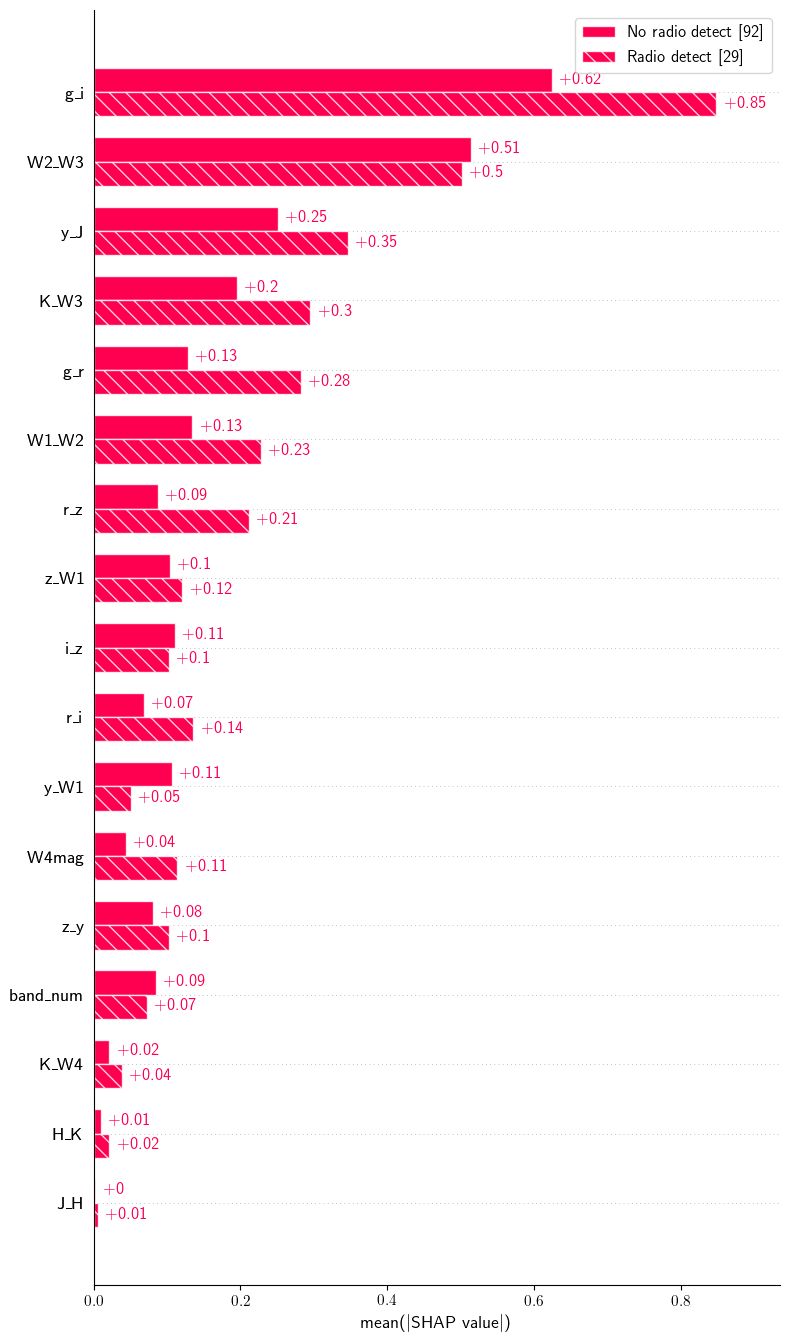

rf


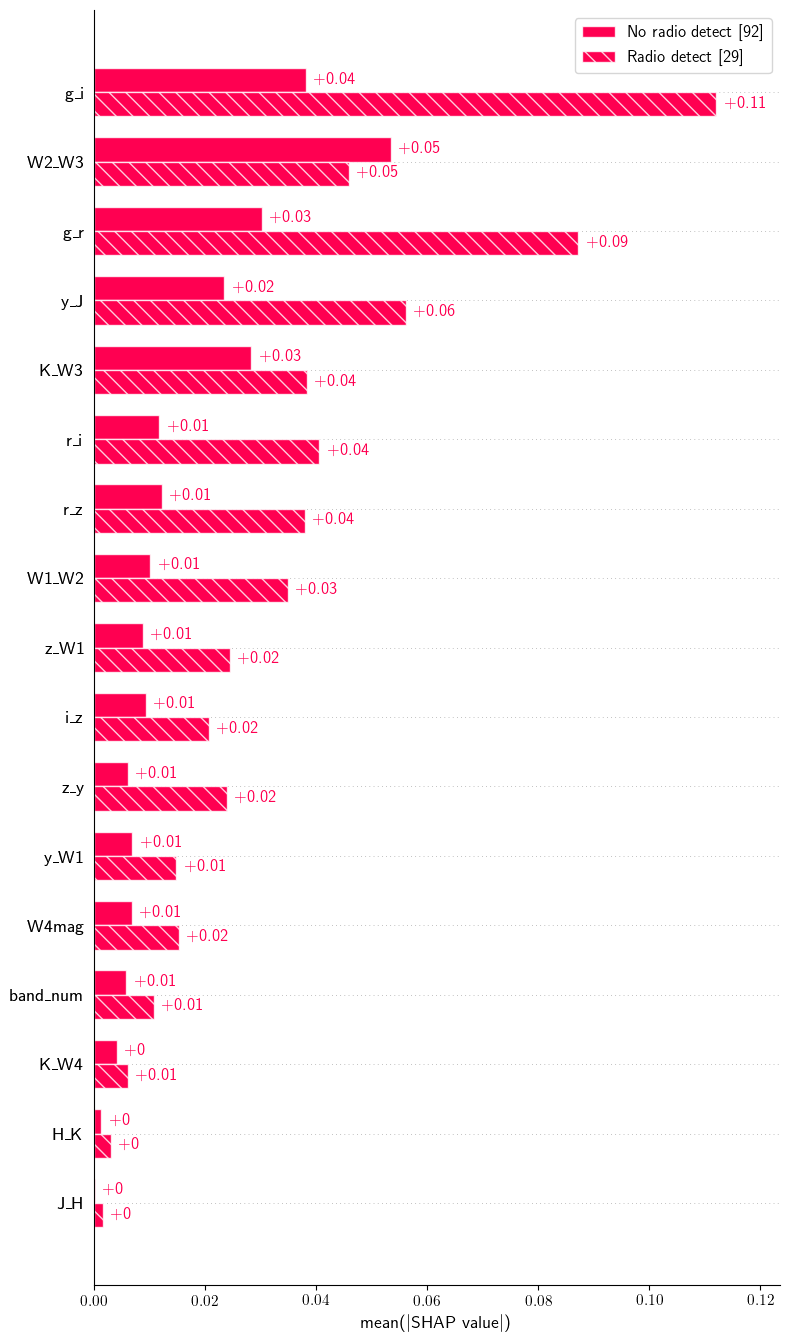

et


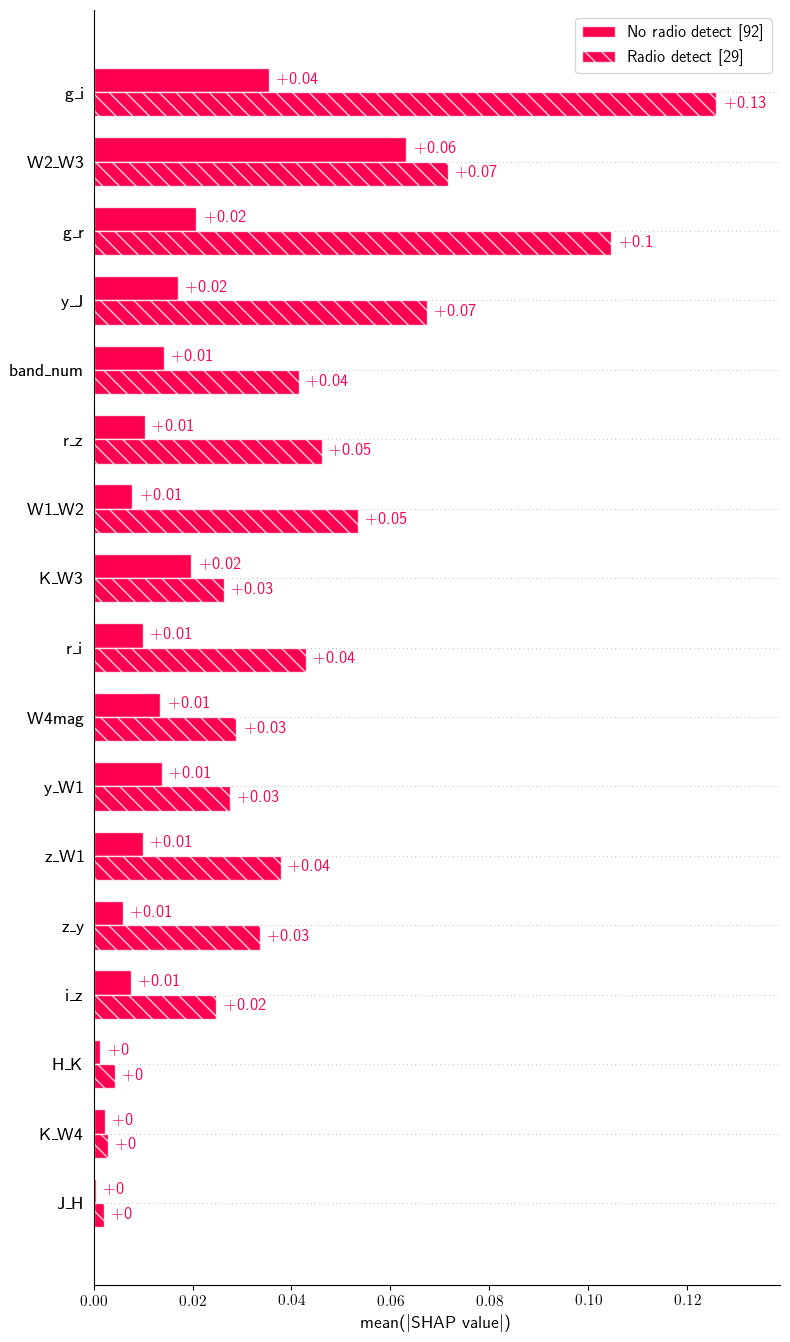

In [60]:
if run_shap_radio_base:
    radio_labels = ['No radio detect' if elem == 0 else 'Radio detect' for elem in reduced_data_radio.loc[:, 'LOFAR_detect']]
    for model in shap_values_radio_base.keys():
        print(f'{model}')
        if np.ndim(shp_copies_radio[model].values) == 2:
            shap.plots.bar(shap_values=shp_copies_radio[model].cohorts(radio_labels).abs.mean(0), max_display=None, show=False)
        elif np.ndim(shp_copies_radio[model].values) > 2:
            shap.plots.bar(shap_values=shp_copies_radio[model][:, :, 1].cohorts(radio_labels).abs.mean(0), max_display=None, show=False)
        plt.gca().set_xlabel('mean($\\vert$SHAP value$\\vert$)')
        plt.tight_layout()
        plt.show()

In [61]:
if run_shap_radio_base:
    for count, model in enumerate(shap_values_radio_base.keys()):
        print(f'\n{model}:')
        # The model's raw prediction for the first observation.
        print(radio_det_clf.named_steps['trained_model'].estimators_[count].predict(reduced_data_radio_df.drop(columns=base_models_name_radio))[0].round(5))
    
        # The corresponding sum of the mean + shap values
        print((np.array([explainers_radio_base[model].expected_value]).flatten()[-1] + shap_values_radio_base[model].values[0].sum()).round(5))


xgboost:
0
-2.6861

catboost:
0
-2.52423

rf:
0
0.12652

et:
0
0.12648


---

#### SHAP - First redshift prediction model

In [62]:
if run_shap_z_base:
    model_name_z = type(redshift_reg.named_steps['trained_model'].final_estimator_).__name__.replace('Regressor', '')

SHAP does not need to use the full dataset for its analysis. Around $N=1000$ (or less) is a good number.

In [63]:
if run_shap_z_base:
    sample_size_z        = 1000
    if use_high_z_sources:
        filter_pred_rAGN = np.ones_like(full_catalog_df.loc[:, 'pred_radio_AGN']).astype(bool)
    elif not use_high_z_sources:
        filter_pred_rAGN = np.array(full_catalog_df.loc[:, 'pred_radio_AGN'] == 1)
    sample_size_z        = np.nanmin([sample_size_z, np.sum(filter_pred_rAGN)])
    print(f'Number of selected elements: {sample_size_z:,}')

Number of selected elements: 121


In [64]:
if run_shap_z_base:
    base_models_name_z = gf.get_base_estimators_names(redshift_reg)

In [65]:
if run_shap_z_base:
    reduced_data_z    = full_catalog_df.loc[filter_pred_AGN].sample(n=sample_size_z, random_state=gv.seed).copy()
    display(reduced_data_z.loc[:, ['Z', 'pred_Z']].describe())
    reduced_data_z_df = gf.preprocess_data(redshift_reg, reduced_data_z, base_models_name_z)
    reduced_cols_z    = reduced_data_z_df.columns.drop(base_models_name_z)

Z      pred_Z
count  121.000000  121.000000
mean     4.456719    3.529207
std      0.510382    0.833137
min      4.000000    0.584000
25%      4.115000    3.220000
50%      4.289000    3.797000
75%      4.623000    4.080000
max      6.580000    4.796000

Use FastTreeSHAP package

In [66]:
if run_shap_z_base:
    explainers_z_base           = {}
    for model, model_fit in zip(redshift_reg.named_steps['trained_model'].estimators, redshift_reg.named_steps['trained_model'].estimators_):
        explainers_z_base[model[0]] = fasttreeshap.TreeExplainer(model_fit, data=None, feature_perturbation='tree_path_dependent',\
                                                                 model_output='raw', feature_dependence='independent', algorithm='auto',
                                                                 n_jobs=12)

In [67]:
if run_shap_z_base:
    shap_values_z_base = {}
    for model in explainers_z_base.keys():
        print(f'Working with base model {model}')
        shap_values_z_base[model] = explainers_z_base[model](reduced_data_z_df.drop(columns=base_models_name_z))

Working with base model rf
Working with base model catboost
Working with base model xgboost
Working with base model gbr


In [68]:
if run_shap_z_base:
    print('Expected "logit" values per base model')
    print('-' * 30)
    for model in explainers_z_base.keys():
        try:
            print(f'{model: <10}\t: {explainers_z_base[model].expected_value[-1]: .4f}')
        except:
            print(f'{model: <10}\t: {explainers_z_base[model].expected_value: .4f}')

Expected "logit" values per base model
------------------------------
rf        	:  1.3230
catboost  	:  1.3233
xgboost   	:  1.3233
gbr       	:  1.3233


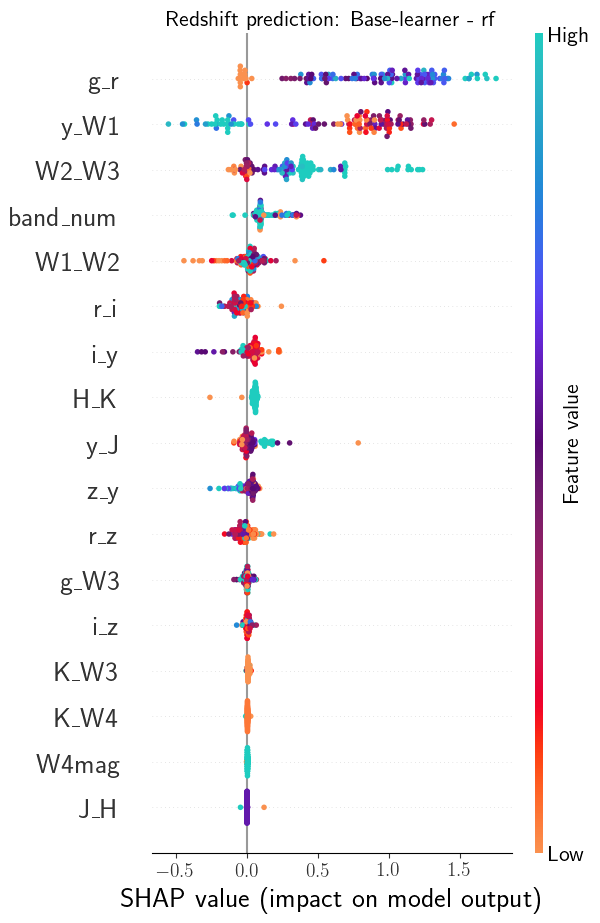

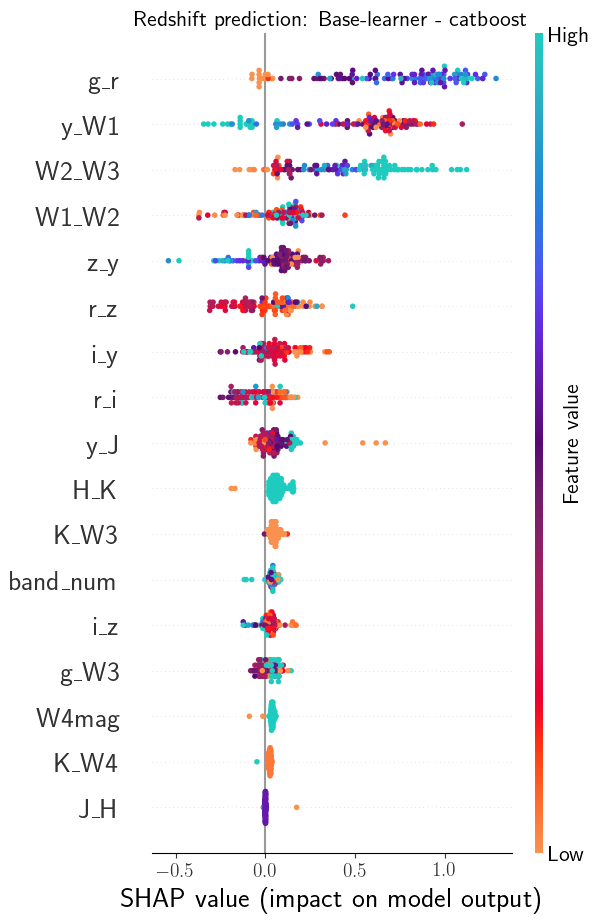

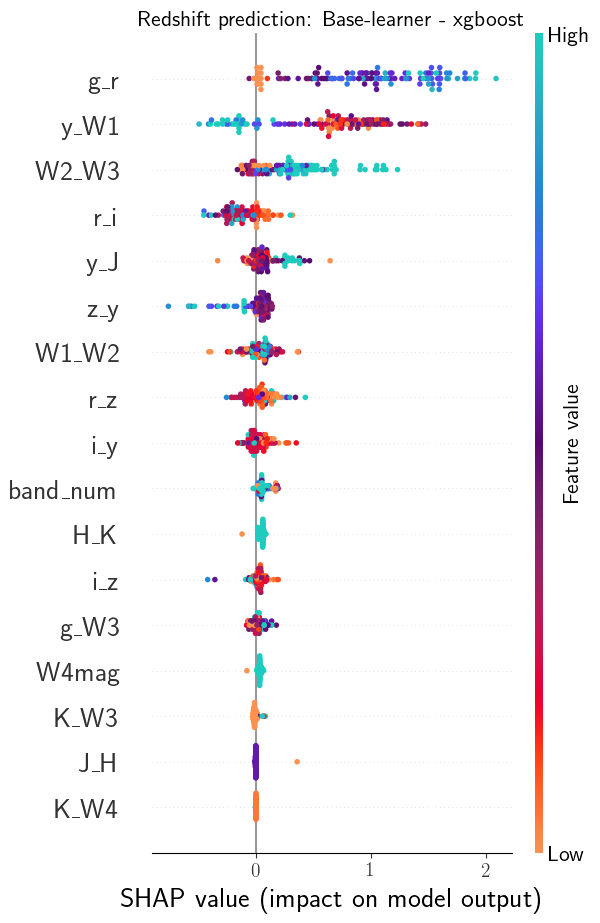

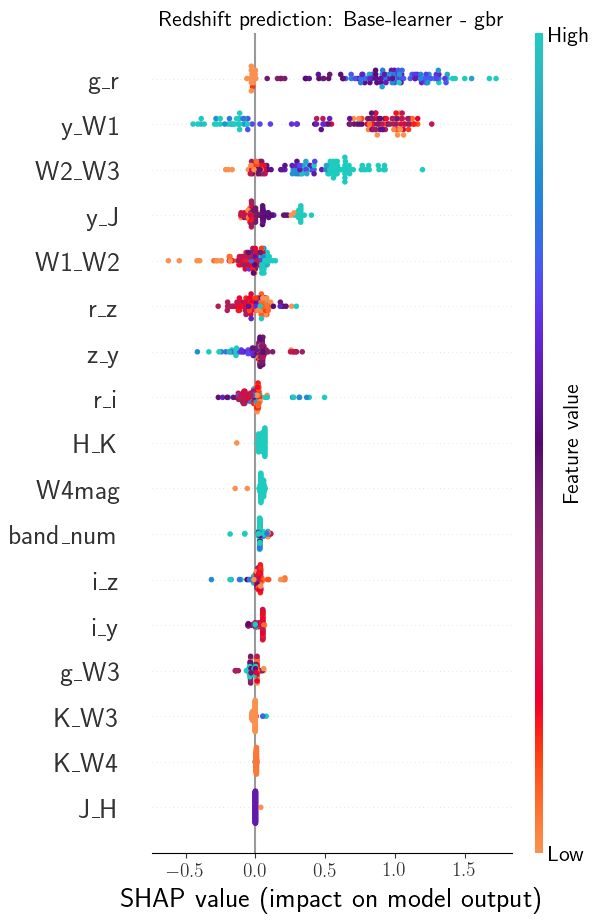

In [69]:
if run_shap_z_base:
    for model in shap_values_z_base.keys():
        gf.plot_shap_beeswarm('Redshift prediction', model, shap_values_z_base[model], base_meta='Base')
        if save_plot_flag:
            plt.savefig(gv.plots_path + f'SHAP_z_base_{model}_{used_area}{subset_str}{high_z_str}.pdf', bbox_inches='tight')
        plt.show()

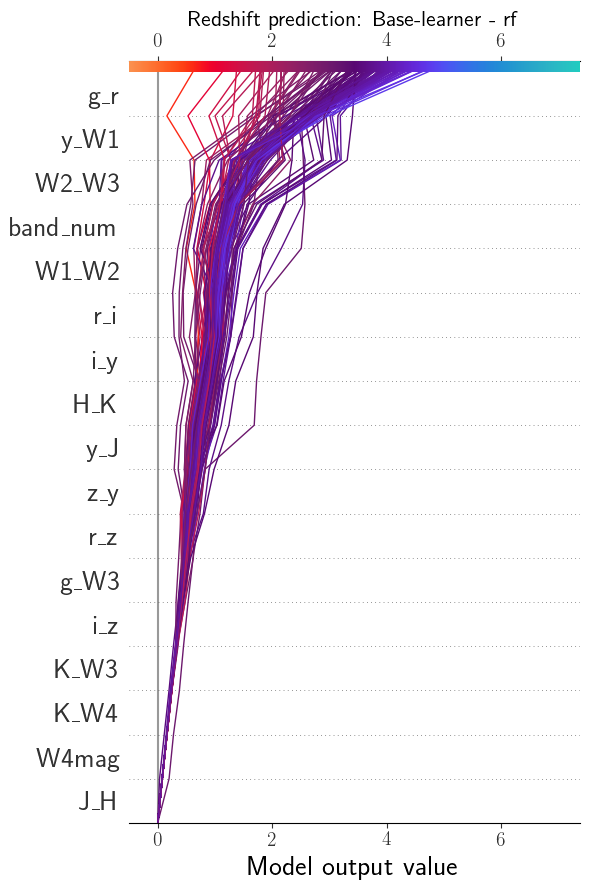

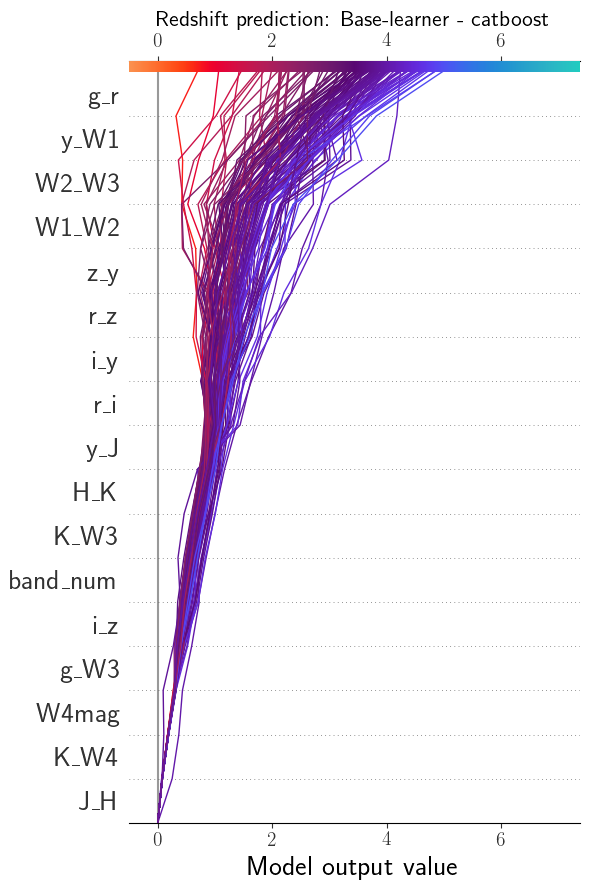

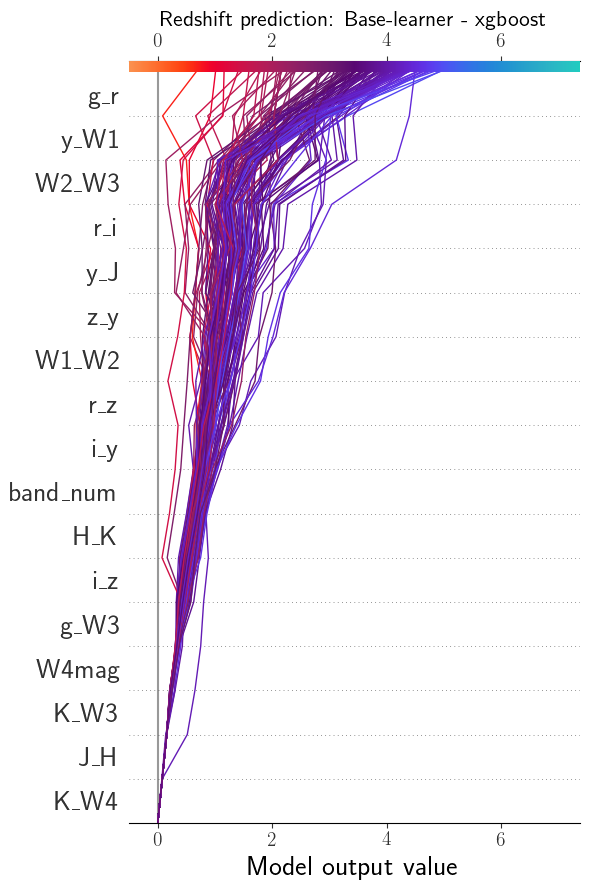

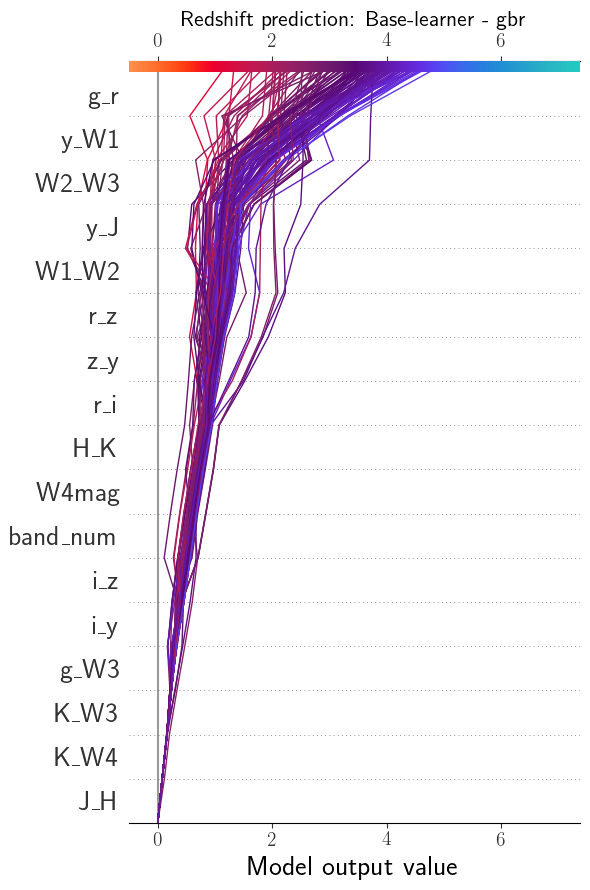

In [70]:
if run_shap_z_base:
    xlims_plt_z         = (-0.5, full_catalog_df.loc[reduced_data_z_df.index, ['Z', 'pred_Z']].max().max() + 0.8)
    for model in shap_values_z_base.keys():
        size_side       = 6
        fig             = plt.figure(figsize=(size_side, size_side * 3/2))
        ax1             = fig.add_subplot(111, xscale='linear', yscale='linear')
        _ = gf.plot_shap_decision('Redshift prediction', model, shap_values_z_base[model], explainers_z_base[model],\
                                  reduced_cols_z, ax1, 'identity', new_base_value=0.0, base_meta='Base', xlim=xlims_plt_z)
        if save_plot_flag:
            plt.savefig(gv.plots_path + f'SHAP_decision_z_base_{model}_{used_area}{subset_str}{high_z_str}.pdf', bbox_inches='tight')
        plt.show()

In [71]:
if run_shap_z_base:
    sorted_mean_abs_SHAP_z = gf.mean_abs_SHAP_base_models(shap_values_z_base, list(shap_values_z_base.keys()))
    for key in shap_values_z_base.keys():
        sorted_mean_abs_SHAP_z[key].loc[:, 'Mean_abs_SHAP'] = sorted_mean_abs_SHAP_z[key].loc[:, 'Mean_abs_SHAP'] /\
                                                              sorted_mean_abs_SHAP_z[key].loc[:, 'Mean_abs_SHAP'].sum() * 100
    multicol_feat_z = [(key, name) for key in sorted_mean_abs_SHAP_z.keys() for name in ('Feature', 'Mean_abs_SHAP')]

In [72]:
if run_shap_z_base:
    sorted_mean_abs_SHAP_z_base_full_df = pd.concat([sorted_mean_abs_SHAP_z[key].reset_index(drop=True) for key in shap_values_z_base.keys()], axis=1)
    sorted_mean_abs_SHAP_z_base_full_df.columns = pd.MultiIndex.from_tuples(multicol_feat_z)
    print('Mean absolute SHAP values scaled to sum 100')
    with pd.option_context('display.float_format', '{:.3f}'.format):
        display(sorted_mean_abs_SHAP_z_base_full_df)

Mean absolute SHAP values scaled to sum 100


rf                catboost                 xgboost                \
     Feature Mean_abs_SHAP   Feature Mean_abs_SHAP   Feature Mean_abs_SHAP   
0        g_r        35.645       g_r        26.645       g_r        34.332   
1       y_W1        27.457      y_W1        19.377      y_W1        23.483   
2      W2_W3        13.857     W2_W3        16.847     W2_W3        11.929   
3   band_num         5.303     W1_W2         5.489       r_i         4.833   
4      W1_W2         2.932       z_y         5.165       y_J         3.687   
5        r_i         2.549       r_z         4.943       z_y         3.642   
6        i_y         2.473       i_y         3.482     W1_W2         3.447   
7        H_K         2.275       r_i         3.372       r_z         3.234   
8        y_J         2.089       y_J         2.837       i_y         2.313   
9        z_y         1.866       H_K         2.610  band_num         2.294   
10       r_z         1.752      K_W3         1.964       H_K         1.766   
11      g_W3         0.582  band_num         1.653       i_z         1.662   
12       i_z         0.499       i_z         1.561      g_W3         1.469   
13      K_W3         0.339      g_W3         1.495     W4mag         1.211   
14      K_W4         0.160     W4mag         1.468      K_W3         0.507   
15     W4mag         0.146      K_W4         1.001       J_H         0.153   
16       J_H         0.075       J_H         0.090      K_W4         0.038   

         gbr                
     Feature Mean_abs_SHAP  
0        g_r        32.662  
1       y_W1        26.447  
2      W2_W3        15.269  
3        y_J         3.593  
4      W1_W2         3.182  
5        r_z         3.057  
6        z_y         2.957  
7        r_i         2.659  
8        H_K         1.957  
9      W4mag         1.872  
10  band_num         1.777  
11       i_z         1.526  
12       i_y         1.290  
13      g_W3         1.014  
14      K_W3         0.484  
15      K_W4         0.225  
16       J_H         0.029

In [73]:
if run_shap_z_base:
    sorted_mean_abs_SHAP_z = pd.read_hdf(gv.tmp_shap_path + f'mean_abs_SHAP_z_meta_{used_area}{subset_str}{high_z_str}.h5', key='df')

In [74]:
if run_shap_z_base:
    print('Combined mean absolute SHAP values scaled to sum 100')
    sorted_mean_abs_SHAP_z_comb = sorted_mean_abs_SHAP_z.copy().set_index('Feature')
    for key in shap_values_z_base.keys():
        factor = sorted_mean_abs_SHAP_z.set_index('Feature').loc[key] / 100
        tmp_feat_imp = sorted_mean_abs_SHAP_z_base_full_df.loc[:, key].copy().set_index('Feature')
        sorted_mean_abs_SHAP_z_comb = sorted_mean_abs_SHAP_z_comb + tmp_feat_imp * factor
    sorted_mean_abs_SHAP_z_comb = sorted_mean_abs_SHAP_z_comb.sort_values(by=['Mean_abs_SHAP'],
                                                                              ascending=False).drop(index=list(shap_values_z_base.keys()))
    sorted_mean_abs_SHAP_z_comb['Cumulative_sum'] = sorted_mean_abs_SHAP_z_comb.loc[:, 'Mean_abs_SHAP'].cumsum()
    with pd.option_context('display.float_format', '{:.3f}'.format):
        display(sorted_mean_abs_SHAP_z_comb)

Combined mean absolute SHAP values scaled to sum 100


Mean_abs_SHAP  Cumulative_sum
Feature                                
g_r              32.594          32.594
y_W1             20.770          53.363
W2_W3            12.462          65.825
W1_W2             5.692          71.518
r_i               4.381          75.899
r_z               3.755          79.654
z_y               3.557          83.211
y_J               3.010          86.221
band_num          2.595          88.816
i_y               2.381          91.196
H_K               2.230          93.427
i_z               2.005          95.431
W4mag             1.639          97.071
g_W3              1.479          98.550
K_W3              0.853          99.403
K_W4              0.451          99.854
J_H               0.146         100.000

rf


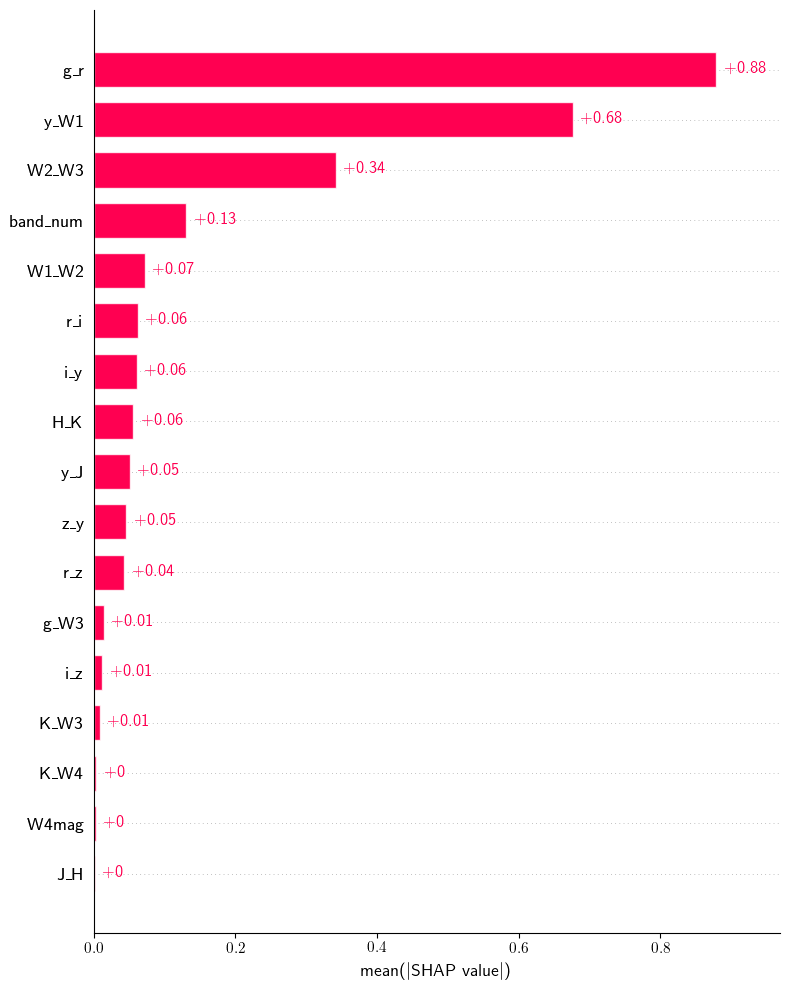

catboost


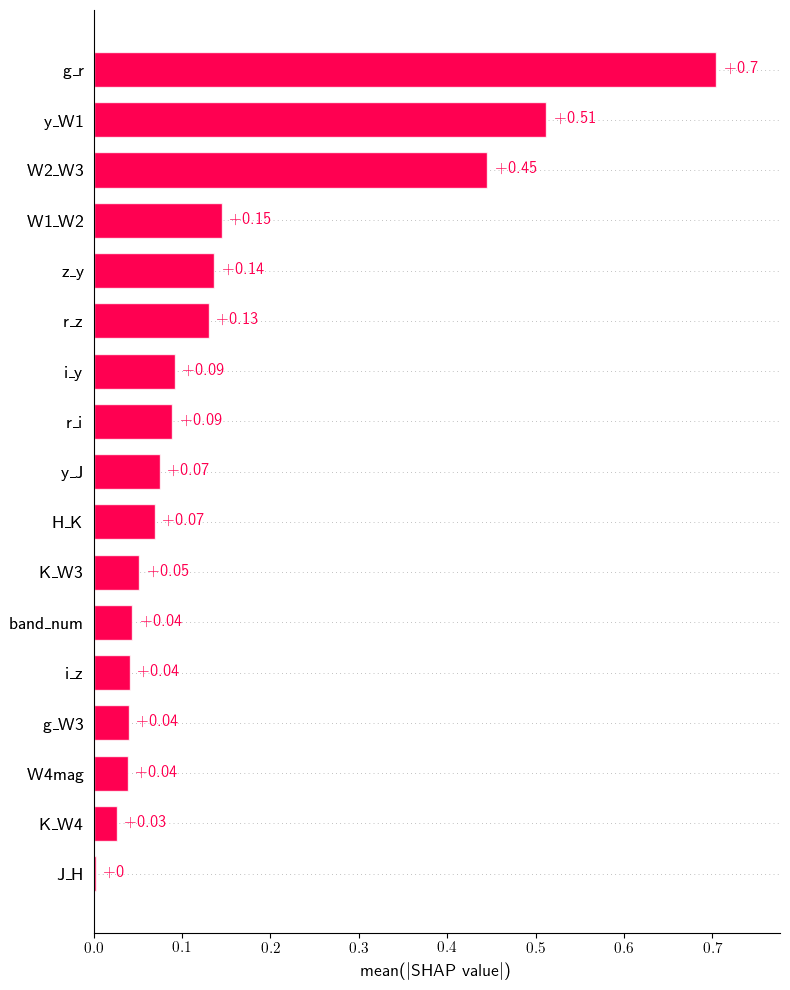

xgboost


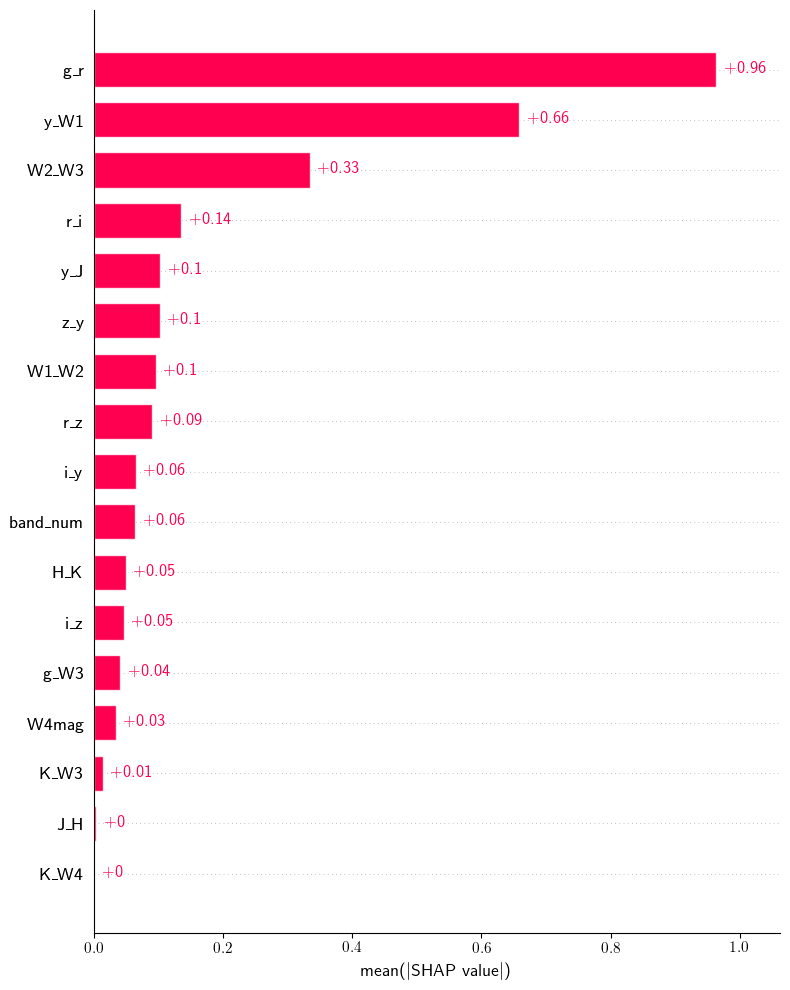

gbr


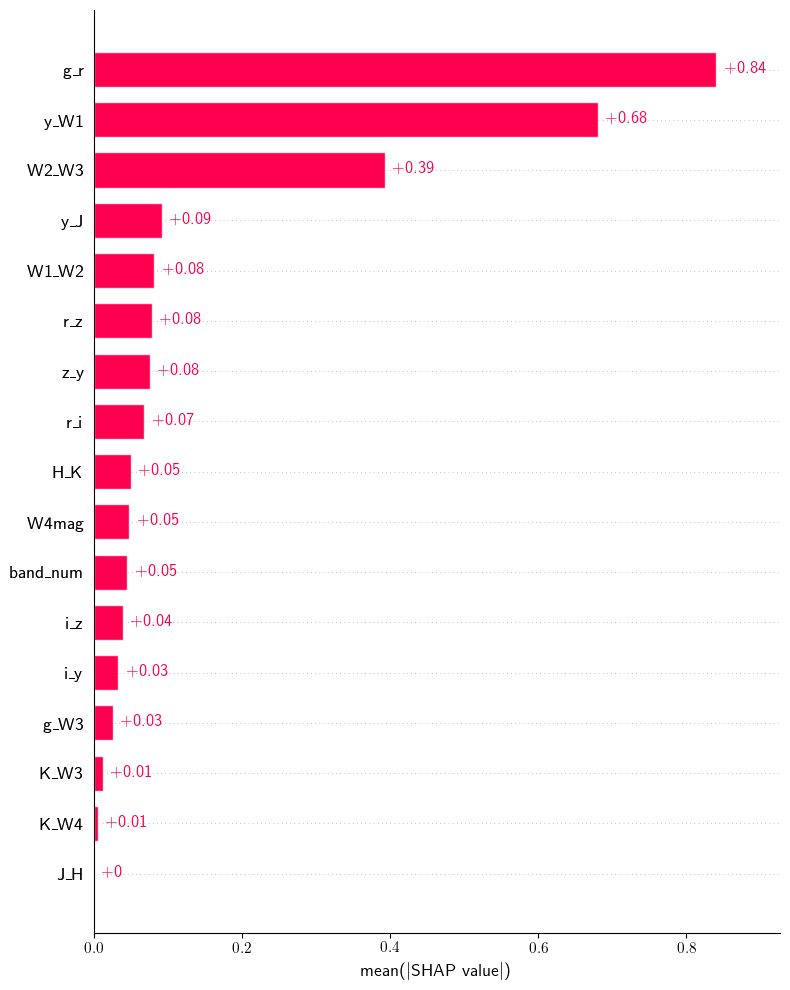

In [75]:
if run_shap_z_base:
    shp_copies_z = {}
    for model in shap_values_z_base.keys():
        # Convert from FastTreeShap to Shap object
        shp_copies_z[model] = shap.Explanation(values=shap_values_z_base[model].values,\
                                               base_values=shap_values_z_base[model].base_values,\
                                               data=shap_values_z_base[model].data,\
                                               feature_names=shap_values_z_base[model].feature_names)
        print(f'{model}')
        if np.ndim(shp_copies_z[model].values) == 2:
            shap.plots.bar(shap_values=shp_copies_z[model], max_display=None, show=False)
        elif np.ndim(shp_copies_z[model].values) > 2:
            shap.plots.bar(shap_values=shp_copies_z[model][:, :, 1], max_display=None, show=False)
        plt.gca().set_xlabel('mean($\\vert$SHAP value$\\vert$)')
        plt.tight_layout()
        plt.show()

In [76]:
if run_shap_z_base:
    for count, model in enumerate(shap_values_z_base.keys()):
        print(f'\n{model}:')
        # The model's raw prediction for the first observation.
        print(redshift_reg.named_steps['trained_model'].estimators_[count].predict(reduced_data_z_df.drop(columns=base_models_name_z))[0].round(5))
    
        # The corresponding sum of the mean + shap values
        try:
            print((explainers_z_base[model].expected_value[-1] + shap_values_z_base[model].values[0].sum()).round(5))
        except:
            print((explainers_z_base[model].expected_value + shap_values_z_base[model].values[0].sum()).round(5))


rf:
4.19907
4.19907

catboost:
3.37606
3.37606

xgboost:
4.91914
4.91914

gbr:
3.81583
3.81583


---

#### SHAP - Second redshift prediction model

In [77]:
if not use_second_z_model: run_shap_high_z_meta = False

In [78]:
if run_shap_high_z_base & use_second_z_model:
    model_name_high_z = type(redshift_reg_2.named_steps['trained_model'].final_estimator_).__name__.replace('Regressor', '')

SHAP does not need to use the full dataset for its analysis. Around $N=1000$ is a good number.

In [79]:
if run_shap_high_z_base & use_second_z_model:
    sample_size_high_z          = 1000
    if use_high_z_sources:
        filter_pred_rAGN_high_z = np.ones_like(full_catalog_df.loc[:, 'pred_Z']).astype(bool)
    elif not use_high_z_sources:
        filter_pred_rAGN_high_z = np.array(full_catalog_df.loc[:, 'pred_radio_AGN'] == 1) &\
                                    np.array(full_catalog_df.loc[:, 'pred_Z'] >= (gv.high_z_limit + redshift_tol))
    sample_size_high_z          = np.nanmin([sample_size_high_z, np.sum(filter_pred_rAGN_high_z)])
    print(f'Number of selected elements: {sample_size_high_z:,}')

In [80]:
if run_shap_high_z_base & use_second_z_model:
    base_models_name_high_z = gf.get_base_estimators_names(redshift_reg_2)

In [81]:
if run_shap_high_z_base & use_second_z_model:
    reduced_data_high_z    = full_catalog_df.loc[filter_pred_AGN].sample(n=sample_size_high_z, random_state=gv.seed).copy()
    display(reduced_data_high_z.loc[:, ['Z', 'pred_Z']].describe())
    reduced_data_high_z_df = gf.preprocess_data(redshift_reg_2, reduced_data_high_z, base_models_name_high_z)
    reduced_cols_high_z    = reduced_data_high_z_df.columns.drop(base_models_name_high_z)

Use FastTreeSHAP package

In [82]:
if run_shap_high_z_base & use_second_z_model:
    explainers_high_z_base           = {}
    for model, model_fit in zip(redshift_reg_2.named_steps['trained_model'].estimators, redshift_reg_2.named_steps['trained_model'].estimators_):
        explainers_high_z_base[model[0]] = fasttreeshap.TreeExplainer(model_fit, data=None, feature_perturbation='tree_path_dependent',\
                                                                      model_output='raw', feature_dependence='independent', algorithm='auto',
                                                                      n_jobs=12)

In [83]:
if run_shap_high_z_base & use_second_z_model:
    shap_values_high_z_base = {}
    for model in explainers_high_z_base.keys():
        print(f'Working with base model {model}')
        shap_values_high_z_base[model] = explainers_high_z_base[model](reduced_data_high_z_df.drop(columns=base_models_name_high_z))

In [84]:
if run_shap_high_z_base & use_second_z_model:
    print('Expected "logit" values per base model')
    print('-' * 30)
    for model in explainers_high_z_base.keys():
        try:
            print(f'{model: <10}\t: {explainers_high_z_base[model].expected_value[-1]: .4f}')
        except:
            print(f'{model: <10}\t: {explainers_high_z_base[model].expected_value: .4f}')

In [85]:
if run_shap_high_z_base & use_second_z_model:
    for model in shap_values_high_z_base.keys():
        gf.plot_shap_beeswarm('High z prediction', model, shap_values_high_z_base[model], base_meta='Base')
        if save_plot_flag:
            plt.savefig(gv.plots_path + f'SHAP_high_z_base_{model}_{used_area}{subset_str}{high_z_str}.pdf', bbox_inches='tight')
        plt.show()

In [86]:
if run_shap_high_z_base & use_second_z_model:
    xlims_plt_hz    = (gv.high_z_limit - 0.4,\
                       full_catalog_df.loc[reduced_data_high_z_df.index, ['Z','pred_Z']].max().max() + 0.8)
    for model in shap_values_high_z_base.keys():
        size_side       = 6
        fig             = plt.figure(figsize=(size_side, size_side * 3/2))
        ax1             = fig.add_subplot(111, xscale='linear', yscale='linear')
        _ = gf.plot_shap_decision('High z prediction', model, shap_values_high_z_base[model],\
                                  explainers_high_z_base[model], reduced_cols_high_z, ax1, 'identity',\
                                  new_base_value=gv.high_z_limit, base_meta='Base', xlim=xlims_plt_hz)
        if save_plot_flag:
            plt.savefig(gv.plots_path + f'SHAP_decision_high_z_base_{model}_{used_area}{subset_str}{high_z_str}.pdf', bbox_inches='tight')
        plt.show()

In [87]:
if run_shap_high_z_base & use_second_z_model:
    sorted_mean_abs_SHAP_high_z = gf.mean_abs_SHAP_base_models(shap_values_high_z_base, list(shap_values_high_z_base.keys()))
    for key in shap_values_high_z_base.keys():
        sorted_mean_abs_SHAP_high_z[key].loc[:, 'Mean_abs_SHAP'] = sorted_mean_abs_SHAP_high_z[key].loc[:, 'Mean_abs_SHAP'] /\
                                                                   sorted_mean_abs_SHAP_high_z[key].loc[:, 'Mean_abs_SHAP'].sum() * 100
    multicol_feat_high_z = [(key, name) for key in sorted_mean_abs_SHAP_high_z.keys() for name in ('Feature', 'Mean_abs_SHAP')]

In [88]:
if run_shap_high_z_base & use_second_z_model:
    sorted_mean_abs_SHAP_high_z_base_full_df = pd.concat([sorted_mean_abs_SHAP_high_z[key].reset_index(drop=True) for key in shap_values_high_z_base.keys()], axis=1)
    sorted_mean_abs_SHAP_high_z_base_full_df.columns = pd.MultiIndex.from_tuples(multicol_feat_high_z)
    print('Mean absolute SHAP values scaled to sum 100')
    with pd.option_context('display.float_format', '{:.3f}'.format):
        display(sorted_mean_abs_SHAP_high_z_base_full_df)

In [89]:
if run_shap_high_z_base & use_second_z_model:
    sorted_mean_abs_SHAP_high_z = pd.read_hdf(gv.tmp_shap_path + f'mean_abs_SHAP_high_z_meta_{used_area}{subset_str}{high_z_str}.h5', key='df')

In [90]:
if run_shap_high_z_base & use_second_z_model:
    print('Combined mean absolute SHAP values scaled to sum 100')
    sorted_mean_abs_SHAP_high_z_comb = sorted_mean_abs_SHAP_high_z.copy().set_index('Feature')
    for key in shap_values_high_z_base.keys():
        factor = sorted_mean_abs_SHAP_high_z.set_index('Feature').loc[key] / 100
        tmp_feat_imp = sorted_mean_abs_SHAP_high_z_base_full_df.loc[:, key].copy().set_index('Feature')
        sorted_mean_abs_SHAP_high_z_comb = sorted_mean_abs_SHAP_high_z_comb + tmp_feat_imp * factor
    sorted_mean_abs_SHAP_high_z_comb = sorted_mean_abs_SHAP_high_z_comb.sort_values(by=['Mean_abs_SHAP'],
                                                                              ascending=False).drop(index=list(shap_values_high_z_base.keys()))
    sorted_mean_abs_SHAP_high_z_comb['Cumulative_sum'] = sorted_mean_abs_SHAP_high_z_comb.loc[:, 'Mean_abs_SHAP'].cumsum()
    with pd.option_context('display.float_format', '{:.3f}'.format):
        display(sorted_mean_abs_SHAP_high_z_comb)

In [91]:
if run_shap_high_z_base & use_second_z_model:
    shp_copies_high_z = {}
    for model in shap_values_high_z_base.keys():
        # Convert from FastTreeShap to Shap object
        shp_copies_high_z[model] = shap.Explanation(values=shap_values_high_z_base[model].values,\
                                                    base_values=shap_values_high_z_base[model].base_values,\
                                                    data=shap_values_high_z_base[model].data,\
                                                    feature_names=shap_values_high_z_base[model].feature_names)
        print(f'{model}')
        if np.ndim(shp_copies_high_z[model].values) == 2:
            shap.plots.bar(shap_values=shp_copies_high_z[model], max_display=None, show=False)
        elif np.ndim(shp_copies_high_z[model].values) > 2:
            shap.plots.bar(shap_values=shp_copies_high_z[model][:, :, 1], max_display=None, show=False)
        plt.gca().set_xlabel('mean($\\vert$SHAP value$\\vert$)')
        plt.tight_layout()
        plt.show()

In [92]:
if run_shap_high_z_base & use_second_z_model:
    for count, model in enumerate(shap_values_high_z_base.keys()):
        print(f'\n{model}:')
        # The model's raw prediction for the first observation.
        print(redshift_reg_2.named_steps['trained_model'].estimators_[count].predict(reduced_data_high_z_df.drop(columns=base_models_name_high_z))[0].round(5))
    
        # The corresponding sum of the mean + shap values
        try:
            print((explainers_high_z_base[model].expected_value[-1] + shap_values_high_z_base[model].values[0].sum()).round(5))
        except:
            print((explainers_high_z_base[model].expected_value + shap_values_high_z_base[model].values[0].sum()).round(5))